In [10]:
# -*- coding: utf-8 -*-
"""
Created on Sun Dec  5 12:53:49 2021

@author: Andrey.Bezrukov
"""

import time
from datetime import datetime
import os
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy import interpolate
from sklearn.cluster import DBSCAN
import numpy as np

##################################################
####### define  functions 
##################################################

class file_Sorption:
    
    def read_file(self, path, filename):
        #print(path +'/'+ filename)        
        try:
            df = pd.read_excel(path + filename, sheet_name='DVS Data')
            if df.columns[0] == 'DVS-INTRINSIC DATA FILE':
                self.filename = filename
                self.instrument = df.columns[0].split()[0]
                self.sample_mass = df.iloc[4, 7]
                self.fluid = 'water vapor'
                comments  = str(df.iloc[3, 1])
                method = str(df.iloc[1, 1])
                df.columns = df.iloc[22, :]
                df = df.iloc[23:, :]
                df = df.reset_index(drop=True)
                df = df.astype('float')
                # renaming columns to common notation
                df = df[['Time (min)', 'dm (%) - ref', 'Target RH (%)', 'Actual RH (%)', 'Target Sample Temp', 'Actual Sample Temp']]
                df.columns = ['time', 'uptake', 'RH_target', 'RH_actual', 'temp_target', 'temp_actual']
                self.temperature = 'Actual Sample Temp: {0:.2f} +- {1:.2f}'.format(df[df.temp_target==df.temp_target.min()].temp_actual.mean(), df[df.temp_target==df.temp_target.min()].temp_actual.std())
                self.equilibration_interval = '---'
                self.comments = comments
                self.method = method
                self.data = df
                #print(self.data.head())
            elif df.columns[0] == 'DVS-Advantage-Plus-Data-File':
                self.filename = filename
                self.instrument = df.columns[0][:-10]
                self.sample_mass = df.iloc[27, 1]
                self.fluid = 'water vapor'
                comments  = str(df.iloc[8, 1])
                method = str(df.iloc[3, 1])
                df.columns = df.iloc[39, :]
                df = df.iloc[40:, :30]
                df = df.reset_index(drop=True)
                df = df[[i for i in df.columns if (i == i) & (i != 'Chiller State')]]
                df = df.astype('float')
                # renaming columns to common notation
                df = df[['Time [minutes]', 'dm (%) - ref', 'Mass [mg]', 'Target Partial Pressure (Solvent A) [%]', 'Measured Partial Pressure (Solvent A) [%]', 'Target Preheater Temp. [celsius]', 'Measured Preheater Temp. [celsius]']]
                df.columns = ['time', 'uptake', 'mass', 'RH_target', 'RH_actual', 'temp_target', 'temp_actual']
                self.temperature = 'Temp. [celsius]: {0:.2f} +- {1:.2f}'.format(df[df.temp_target==df.temp_target.min()].temp_actual.mean(), df[df.temp_target==df.temp_target.min()].temp_actual.std())
                self.equilibration_interval = '---'
                self.comments = comments
                self.method = method
                self.data = df
                #print(self.data.head())
        except Exception as e:
            print(e)
        #print(self.__dict__.keys())
        # test if import was correct
        if (list(self.__dict__.keys()) == ['filename', 'instrument', 'sample_mass', 'fluid', 'temperature', 'equilibration_interval', 'comments', 'method', 'data'])  :
            print('File {0} read succesfull'.format(filename))
            self.import_success = True
        else:
            self.import_success = False


def Create_WaterSorption_isotherm(Sorption):
    if True:
        Sorption.data['cycle_split'] = Sorption.data['RH_target'].diff().fillna(0)
        split_index_ads = Sorption.data.index[(Sorption.data['cycle_split']>0)].to_list()
        split_index_des = Sorption.data.index[(Sorption.data['cycle_split']<0)].to_list()
        
        index_tuple = [('ads', i) for i in split_index_ads] + [('des', i) for i in split_index_des]
        index_tuple = sorted(index_tuple, key=lambda x: x[1])
        #print(index_tuple)
        isotherm_split = []
        prev = 'ads'
        for i, j in enumerate([i[0] for i in index_tuple]):
            if (j == 'ads')&(prev=='des'):
                isotherm_split.append(index_tuple[i][1])
            prev = j
        print(isotherm_split)
        args = [0]+isotherm_split+[Sorption.data.index.size]
        #args= args[:2]
        print(args)
        
        for start,  end in zip(args, args[1:]):
            print(start,  end)
            split_index_ads = Sorption.data.iloc[start:end].index[(Sorption.data.iloc[start:end]['cycle_split']>0)].to_list()
            split_index_des = Sorption.data.iloc[start:end].index[(Sorption.data.iloc[start:end]['cycle_split']<0)].to_list()
            
            split_index_des.append(Sorption.data.iloc[start:end].index.to_list()[-1])
            split_index_ads = split_index_ads + [split_index_des[0]]
            
            #print(split_index_ads)
            #print(split_index_des)
            isotherm_RHtarget_ads = []
            isotherm_RHactual_ads = []
            isotherm_adsorption = []
            isotherm_RHtarget_des = []
            isotherm_RHactual_des = []
            isotherm_desorption = []
            for i, split in enumerate(split_index_ads[:]):
                isotherm_adsorption.append(Sorption.data[split-10:split].uptake.median())
                if i==0:
                    isotherm_RHtarget_ads.append(Sorption.data[:split_index_ads[i]].RH_target.median())
                    isotherm_RHactual_ads.append(Sorption.data[:split_index_ads[i]].RH_actual.median())
                else:
                    isotherm_RHtarget_ads.append(Sorption.data[split_index_ads[i-1]:split_index_ads[i]].RH_target.median())
                    isotherm_RHactual_ads.append(Sorption.data[split_index_ads[i-1]:split_index_ads[i]].RH_actual.median())
            for i, split in enumerate(split_index_des[:]):
                isotherm_desorption.append(Sorption.data[split-10:split].uptake.median())
                if i == 0:
                    isotherm_RHtarget_des.append(Sorption.data[split_index_ads[-2]:split_index_ads[-1]].RH_target.median())
                    isotherm_RHactual_des.append(Sorption.data[split_index_ads[-2]:split_index_ads[-1]].RH_actual.median())
                else:
                    isotherm_RHtarget_des.append(Sorption.data[split_index_des[i-1]:split_index_des[i]].RH_target.median())
                    isotherm_RHactual_des.append(Sorption.data[split_index_des[i-1]:split_index_des[i]].RH_actual.median())
    return isotherm_RHtarget_ads, [i for i in isotherm_adsorption], isotherm_RHtarget_des, [i for i in isotherm_desorption],  Sorption.data.time.max()- Sorption.data[split_index_ads[0]:split_index_ads[1]].time.min()


In [11]:
window1 = 50
window2 = 10
text_size = 16

result = pd.DataFrame(columns=['name','isotherm','cycleNr','kinetics'], 
                      #dtype=object
                     )

datetime_stamp = datetime.now().isoformat(timespec='seconds')

#os.mkdir(datetime_stamp+'/')

import_parameters = pd.read_csv('input_data.csv', sep=',')
#import_parameters.cycleNr = import_parameters.cycleNr.astype('int32')
print(import_parameters)

                                    path_kinetics  \
0   ../../../../data/water_sorption/DVS/kinetics/   
1   ../../../../data/water_sorption/DVS/kinetics/   
2   ../../../../data/water_sorption/DVS/kinetics/   
3   ../../../../data/water_sorption/DVS/kinetics/   
4   ../../../../data/water_sorption/DVS/kinetics/   
5   ../../../../data/water_sorption/DVS/kinetics/   
6   ../../../../data/water_sorption/DVS/kinetics/   
7   ../../../../data/water_sorption/DVS/kinetics/   
8   ../../../../data/water_sorption/DVS/kinetics/   
9   ../../../../data/water_sorption/DVS/kinetics/   
10  ../../../../data/water_sorption/DVS/kinetics/   
11  ../../../../data/water_sorption/DVS/kinetics/   
12  ../../../../data/water_sorption/DVS/kinetics/   
13  ../../../../data/water_sorption/DVS/kinetics/   
14  ../../../../data/water_sorption/DVS/kinetics/   
15  ../../../../data/water_sorption/DVS/kinetics/   
16  ../../../../data/water_sorption/DVS/kinetics/   
17  ../../../../data/water_sorption/DVS/kineti

path_kinetics            ../../../../data/water_sorption/DVS/kinetics/
filename_kinetics    Syloid_kinetics_50-100um_27C_12mg-2021-07-15 1...
path_isotherm           ../../../../data/water_sorption/DVS/isotherms/
filename_isotherm          syloid_isotherm_25C-2021-03-19 23-03-21.xls
color                                                            green
name                                                       Syloid AL-1
cycleNr                                                           345'
analyze                                                              Y
to_paper                                                           NaN
Name: 0, dtype: object
File Syloid_kinetics_50-100um_27C_12mg-2021-07-15 13-38-52.xls read succesfull
Intersection:  [2.902772573997759, 24.161671037841884]
0.3
2.65
1.4749999999999999
0.8875
0.59375
0.446875
0.3734375
0.33671874999999996
0.318359375
0.3275390625
Fitting parameters: k:  0.3275390625
name 'Sorption_isotherm' is not defined
Intersection:  [3.59

C:\Users\Andrey.Bezrukov\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:230: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.


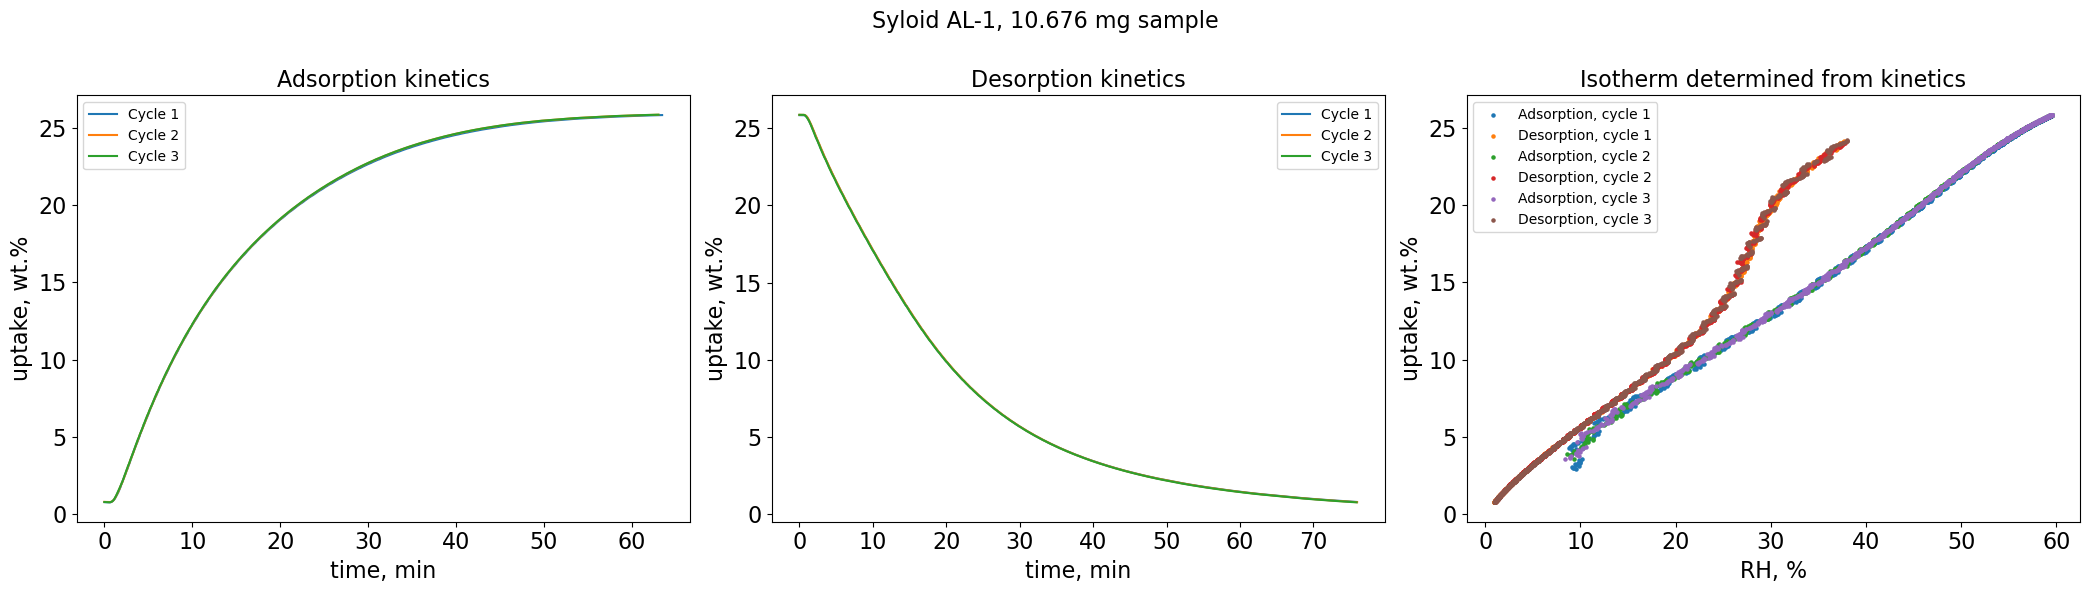

path_kinetics            ../../../../data/water_sorption/DVS/kinetics/
filename_kinetics    MIL-100Fe_SS-2-1232_50-100um_9mg-2022-06-11 19...
path_isotherm           ../../../../data/water_sorption/DVS/isotherms/
filename_isotherm    MIL-100Fe_SS-2-1232_isotherm_27C-2021-07-07 00...
color                                                            green
name                                                         MIL-100Fe
cycleNr                                                           345'
analyze                                                              Y
to_paper                                                           NaN
Name: 1, dtype: object
File MIL-100Fe_SS-2-1232_50-100um_9mg-2022-06-11 19-51-35.xls read succesfull
Intersection:  [5.776386604276792, 46.22386891738665]
0.3
2.65
1.4749999999999999
0.8875
0.59375
0.446875
0.3734375
0.33671874999999996
0.318359375
0.3091796875
Fitting parameters: k:  0.3091796875
name 'Sorption_isotherm' is not defined
Intersection:  [5.9680

C:\Users\Andrey.Bezrukov\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:230: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.


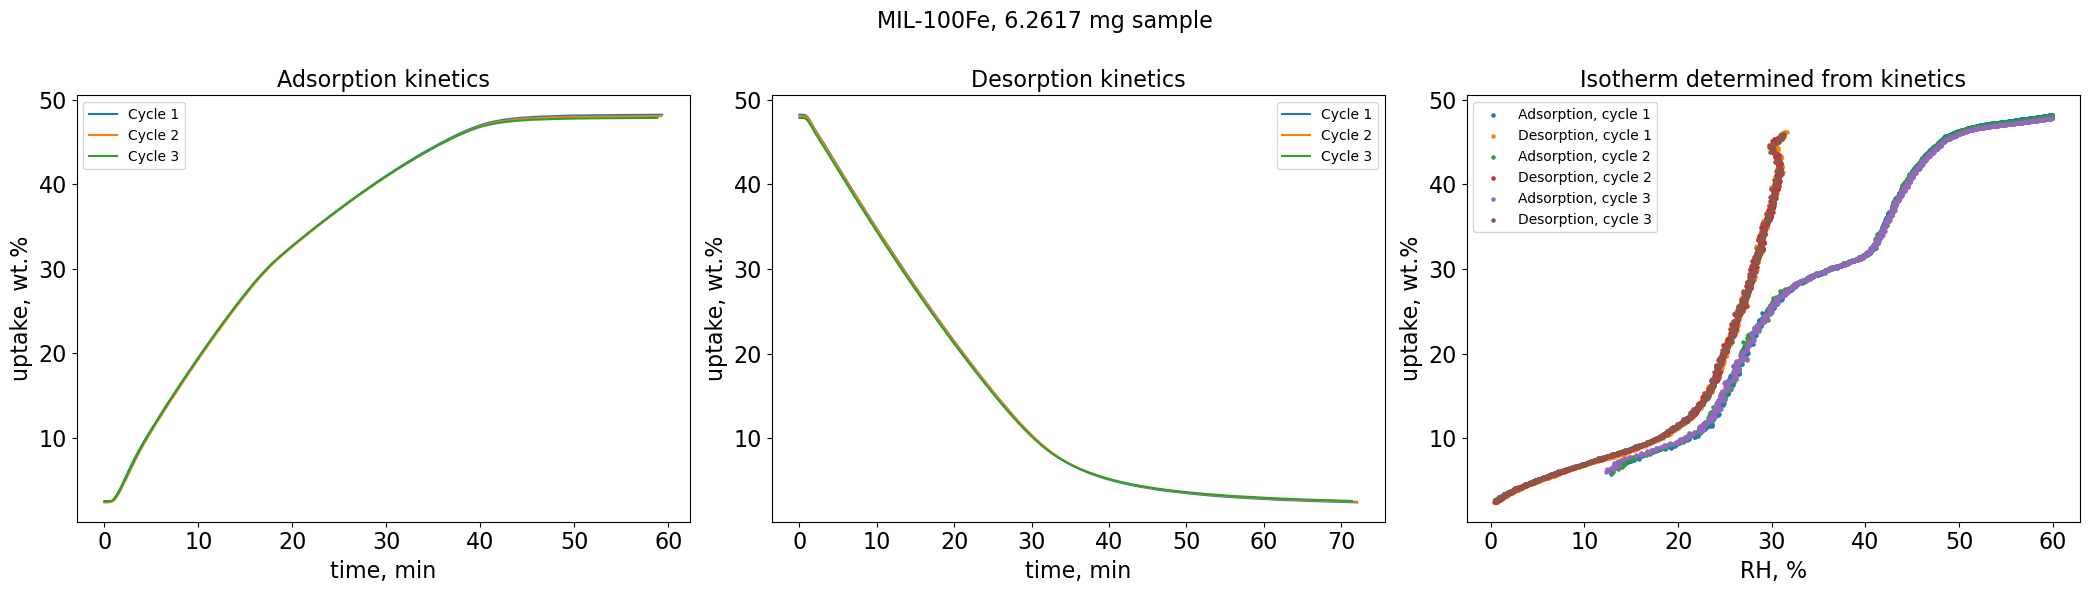

path_kinetics            ../../../../data/water_sorption/DVS/kinetics/
filename_kinetics    Montmorillonite_kinetics_27C_TGApan-2022-10-05...
path_isotherm           ../../../../data/water_sorption/DVS/isotherms/
filename_isotherm    Montmorillonite_isotherm_27C_TGApan-2022-10-04...
color                                                            green
name                                                   montmorillonite
cycleNr                                                            13'
analyze                                                              Y
to_paper                                                           NaN
Name: 2, dtype: object
File Montmorillonite_kinetics_27C_TGApan-2022-10-05 16-50-39.xls read succesfull
Intersection:  [2.7458308450043987, 22.459817501139817]
0.3
0.155
0.22749999999999998
0.26375
0.281875
0.2728125
0.27734375
0.275078125
0.2739453125
0.27337890625
Fitting parameters: k:  0.27337890625
name 'Sorption_isotherm' is not defined
Intersection:  [

C:\Users\Andrey.Bezrukov\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:230: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.


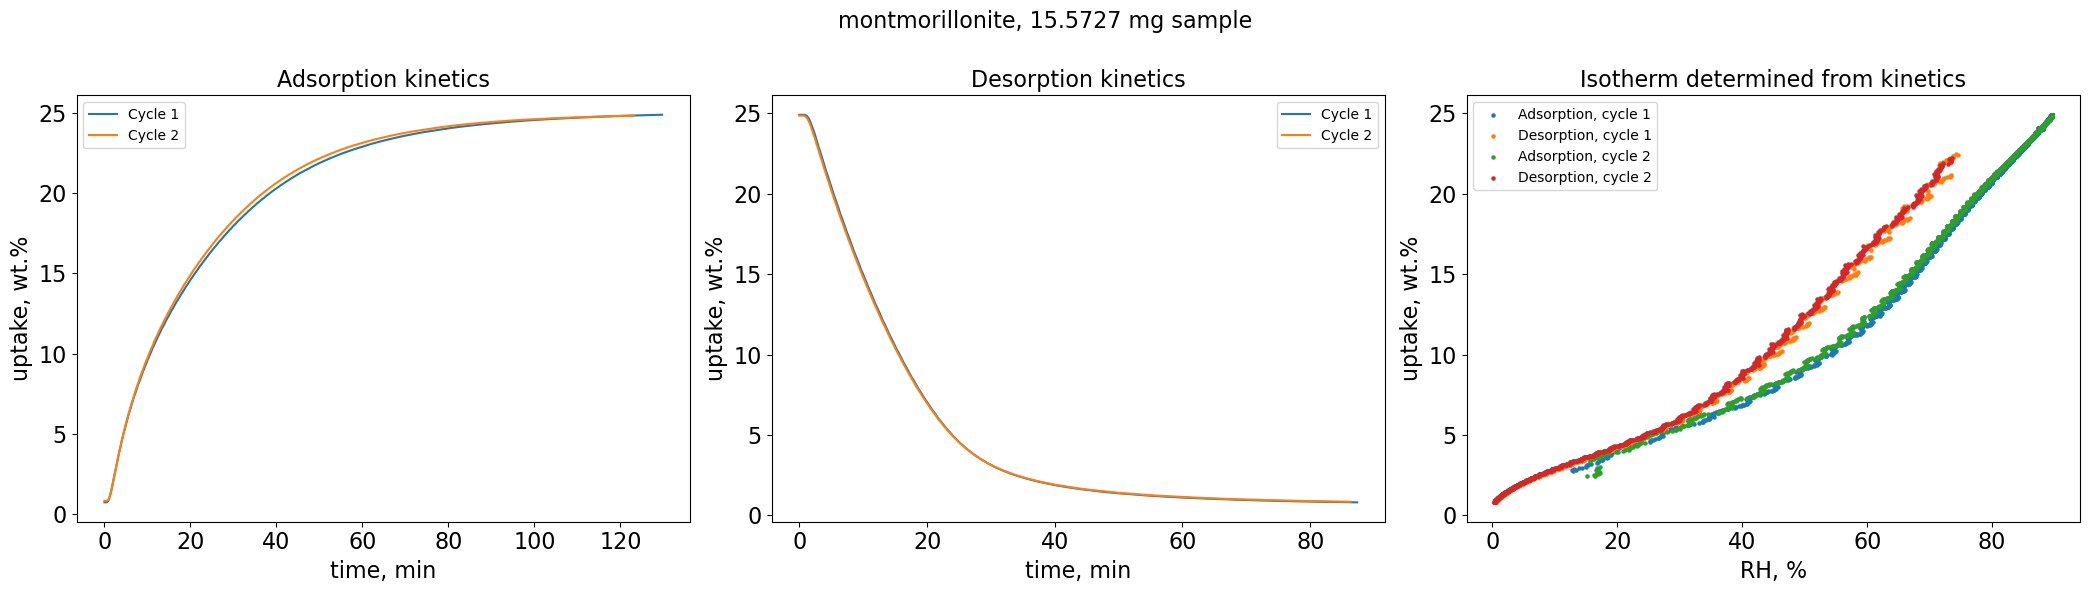

path_kinetics            ../../../../data/water_sorption/DVS/kinetics/
filename_kinetics          HP-MCP_kinetics_27C-2022-08-18 11-35-52.xls
path_isotherm           ../../../../data/water_sorption/DVS/isotherms/
filename_isotherm    HP-MCP_isotherm_27C_TGApan-2022-10-06 11-58-55...
color                                                            green
name                                                            HP-MCP
cycleNr                                                           '13'
analyze                                                              Y
to_paper                                                           NaN
Name: 3, dtype: object
File HP-MCP_kinetics_27C-2022-08-18 11-35-52.xls read succesfull
Intersection:  [1.6132968373841647, 7.6654684562872974]
0.3
0.155
0.22749999999999998
0.26375
0.24562499999999998
0.23656249999999998
0.24109375
0.243359375
0.24449218749999999
0.24505859375
Fitting parameters: k:  0.24505859375
name 'Sorption_isotherm' is not defined
Inte

C:\Users\Andrey.Bezrukov\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:230: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.


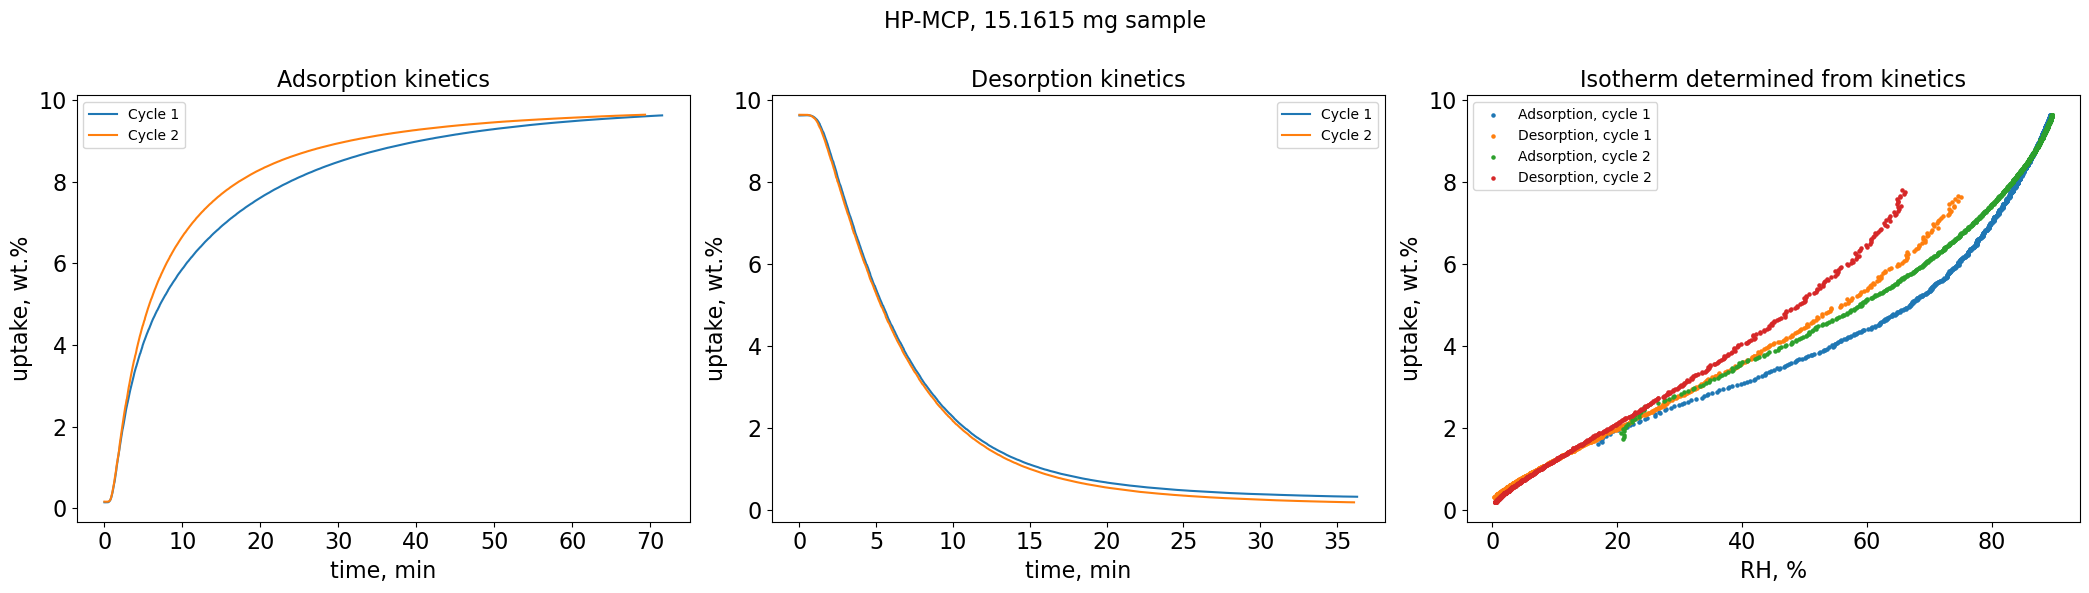

path_kinetics            ../../../../data/water_sorption/DVS/kinetics/
filename_kinetics      KollidonSR_kinetics_27C-2022-08-18 11-35-52.xls
path_isotherm           ../../../../data/water_sorption/DVS/isotherms/
filename_isotherm    KollidonSR_isotherm_27C_TGApan-2022-10-06 11-5...
color                                                            green
name                                                          Kollidon
cycleNr                                                           '13'
analyze                                                              Y
to_paper                                                           NaN
Name: 4, dtype: object
File KollidonSR_kinetics_27C-2022-08-18 11-35-52.xls read succesfull
Intersection:  [1.8179814896430144, 12.217094859098331]
0.3
0.155
0.22749999999999998
0.26375
0.281875
0.29093749999999996
0.29546874999999995
0.297734375
0.29886718749999996
0.29943359375
Fitting parameters: k:  0.29943359375
name 'Sorption_isotherm' is not defined
In

C:\Users\Andrey.Bezrukov\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:230: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.


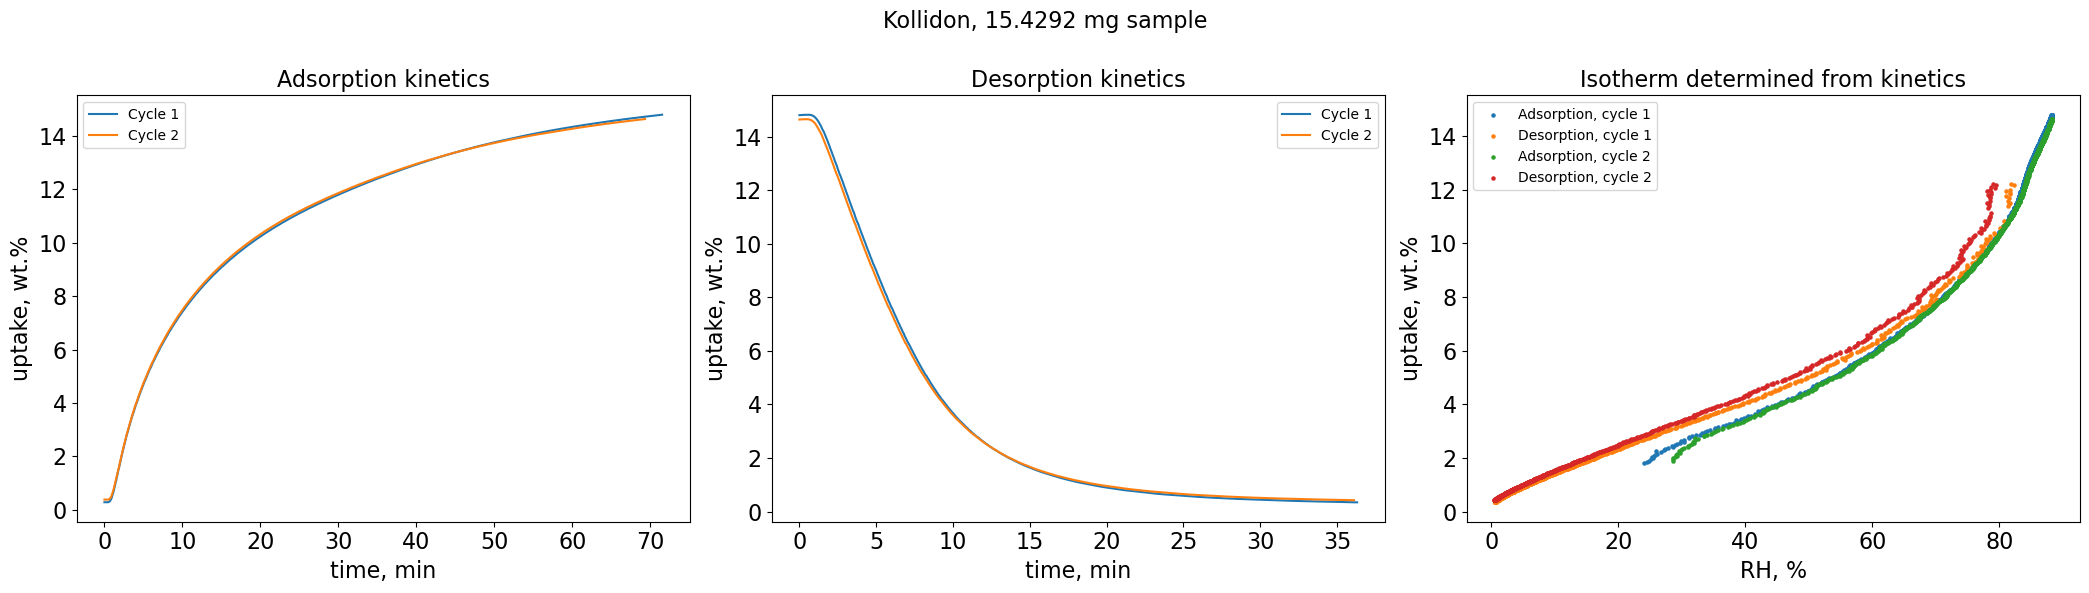

path_kinetics            ../../../../data/water_sorption/DVS/kinetics/
filename_kinetics    Al-fum_NK-1091_50-100um_kinetics_10mg-2022-04-...
path_isotherm           ../../../../data/water_sorption/DVS/isotherms/
filename_isotherm    NK1091_Al-fumarate_EtOH_50-100um_27C_isotherm-...
color                                                            green
name                                                       Al-fumarate
cycleNr                                                          '345'
analyze                                                              Y
to_paper                                                           NaN
Name: 5, dtype: object
File Al-fum_NK-1091_50-100um_kinetics_10mg-2022-04-19 16-39-52.xls read succesfull
Intersection:  [2.770329168569178, 36.00431696484164]
0.3
2.65
1.4749999999999999
0.8875
0.59375
0.446875
0.3734375
0.33671874999999996
0.318359375
0.3275390625
Fitting parameters: k:  0.3275390625
name 'Sorption_isotherm' is not defined
Intersection:  [2

C:\Users\Andrey.Bezrukov\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:230: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.


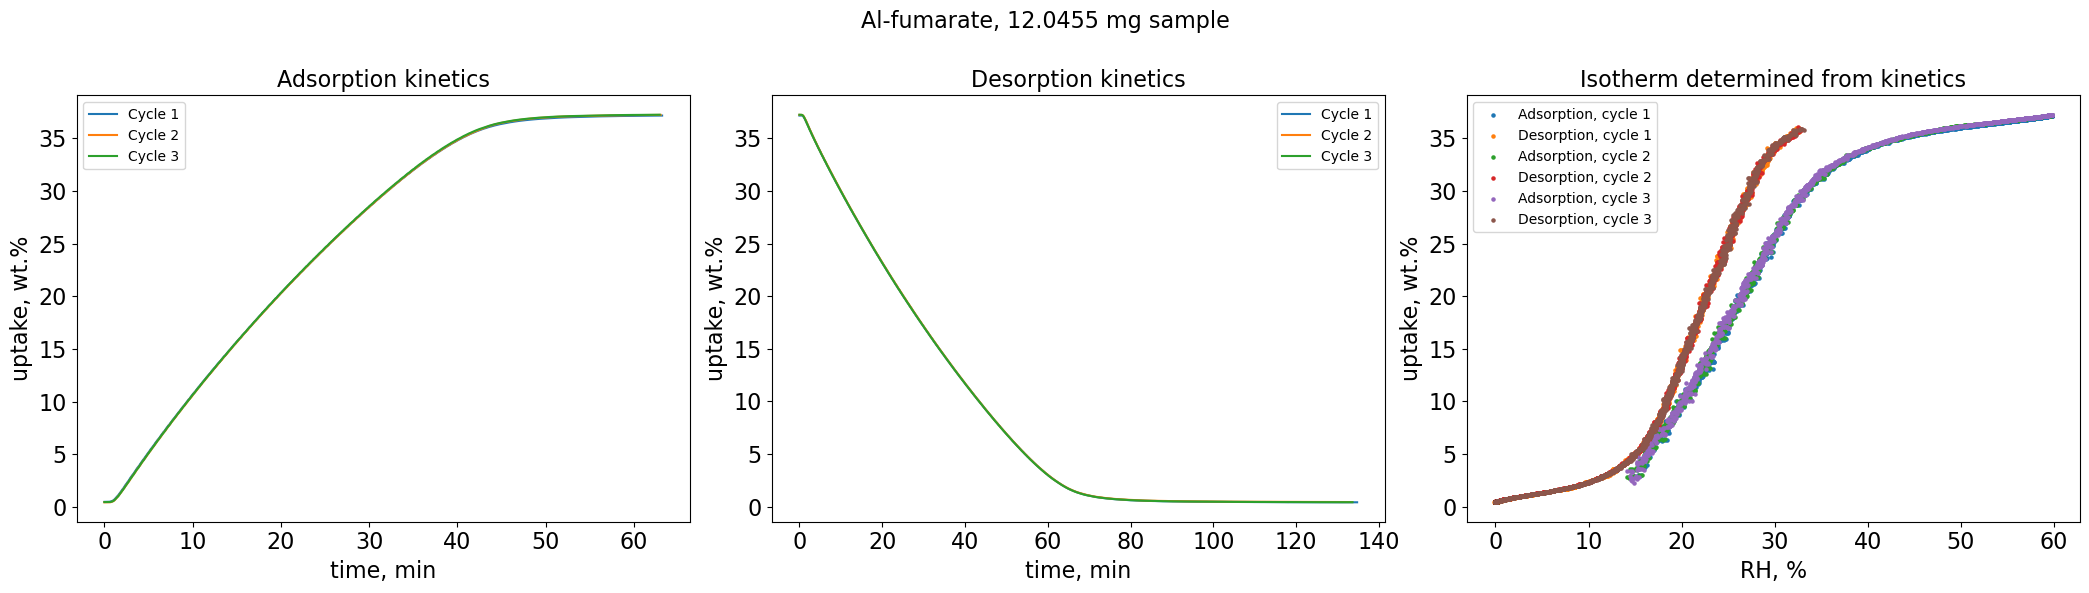

path_kinetics            ../../../../data/water_sorption/DVS/kinetics/
filename_kinetics    MIL-160_DJ2500_kinetics_27C_16mg_50-100um-2021...
path_isotherm           ../../../../data/water_sorption/DVS/isotherms/
filename_isotherm      DJO-02-500_isotherm_27C-2021-05-18 18-59-58.xls
color                                                            green
name                                                           MIL-160
cycleNr                                                            34'
analyze                                                              Y
to_paper                                                           NaN
Name: 6, dtype: object
File MIL-160_DJ2500_kinetics_27C_16mg_50-100um-2021-06-15 17-03-17_1.xls read succesfull
Intersection:  [5.213242273800235, 35.18560520148183]
0.3
2.65
1.4749999999999999
0.8875
0.59375
0.446875
0.3734375
0.41015625
0.391796875
0.4009765625
Fitting parameters: k:  0.4009765625
name 'Sorption_isotherm' is not defined
Intersection:  [4.29

C:\Users\Andrey.Bezrukov\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:230: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.


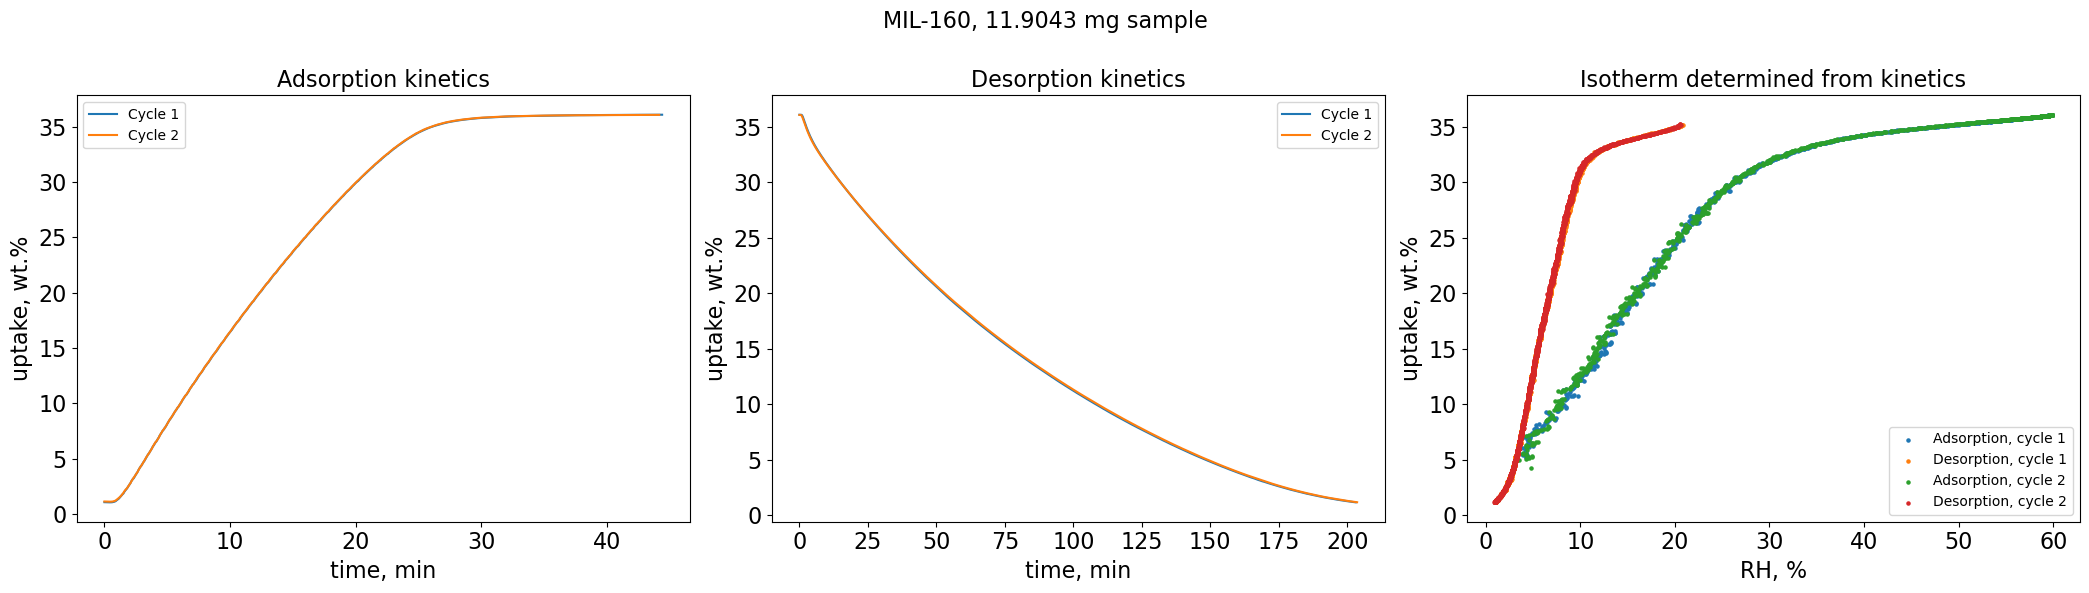

path_kinetics            ../../../../data/water_sorption/DVS/kinetics/
filename_kinetics    MOF-303-SS1131_kinetics_27C_12mg_50-100um-2021...
path_isotherm           ../../../../data/water_sorption/DVS/isotherms/
filename_isotherm    MOF-303_SS-1131_isotherm_27C-2021-06-14 09-53-...
color                                                            green
name                                                           MOF-303
cycleNr                                                            34'
analyze                                                              Y
to_paper                                                           NaN
Name: 7, dtype: object
File MOF-303-SS1131_kinetics_27C_12mg_50-100um-2021-06-03 09-37-23.xls read succesfull
Intersection:  [4.702516453050133, 36.799029203610374]
0.3
2.65
1.4749999999999999
0.8875
0.59375
0.446875
0.3734375
0.33671874999999996
0.318359375
0.3275390625
Fitting parameters: k:  0.3275390625
name 'Sorption_isotherm' is not defined
Intersection

C:\Users\Andrey.Bezrukov\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:230: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.


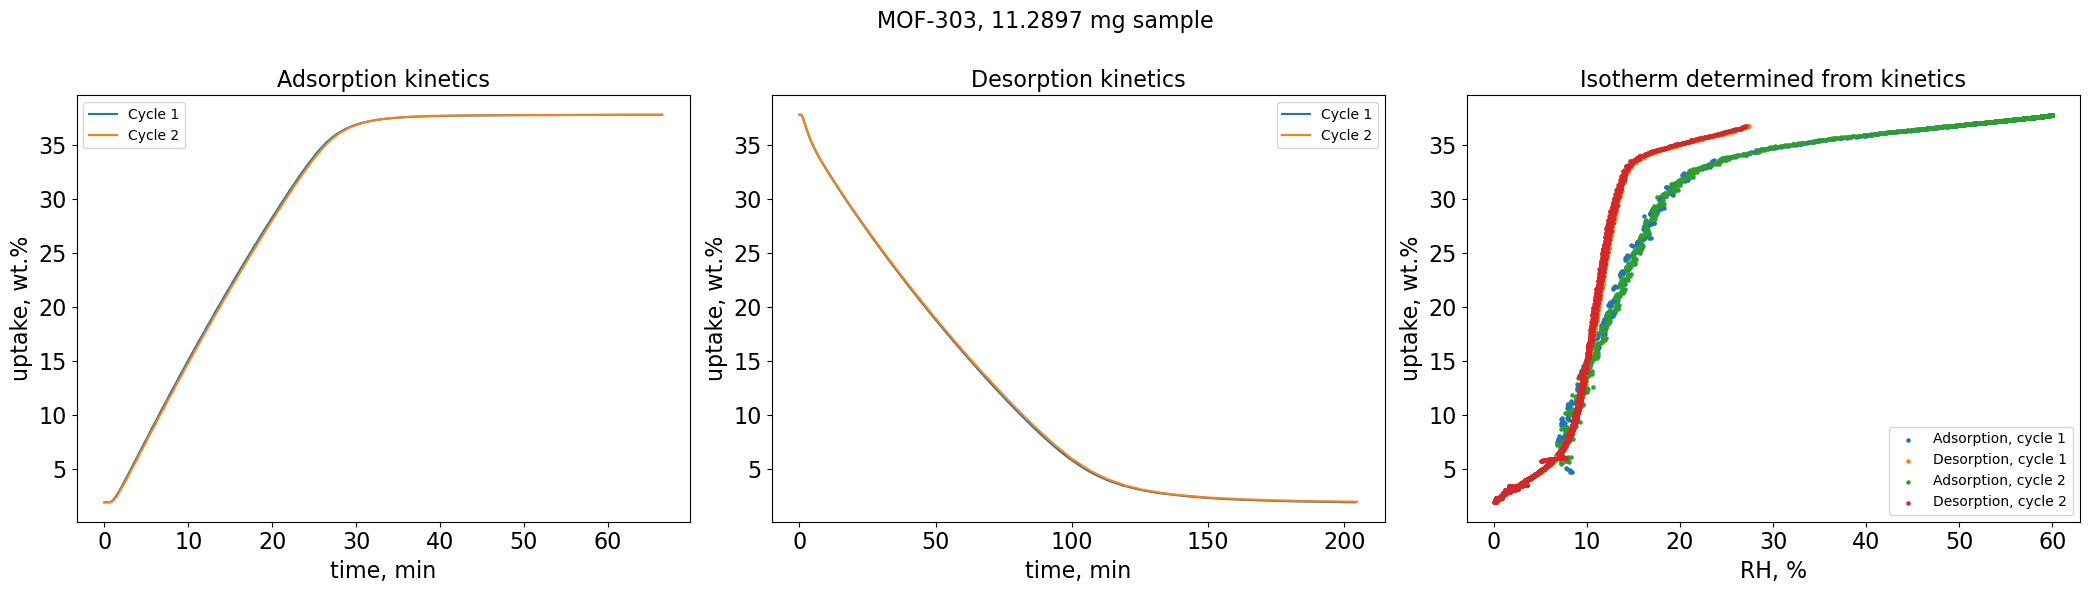

path_kinetics            ../../../../data/water_sorption/DVS/kinetics/
filename_kinetics    ROS-037_50-100um_kinetics_27C_TGApan-2022-10-0...
path_isotherm           ../../../../data/water_sorption/DVS/isotherms/
filename_isotherm        ROS037_-u50_isotherm-2021-05-07 18-07-06.xlsx
color                                                            green
name                                                           ROS-037
cycleNr                                                           '13'
analyze                                                              Y
to_paper                                                           NaN
Name: 8, dtype: object
File ROS-037_50-100um_kinetics_27C_TGApan-2022-10-05 16-50-39.xls read succesfull
Intersection:  [3.5868716910291254, 9.92322132928348]
0.3
0.155
0.22749999999999998
0.26375
0.281875
0.29093749999999996
0.28640625
0.28867187499999997
0.28753906249999994
0.28810546875
Fitting parameters: k:  0.28810546875
name 'Sorption_isotherm' is not 

C:\Users\Andrey.Bezrukov\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:230: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.


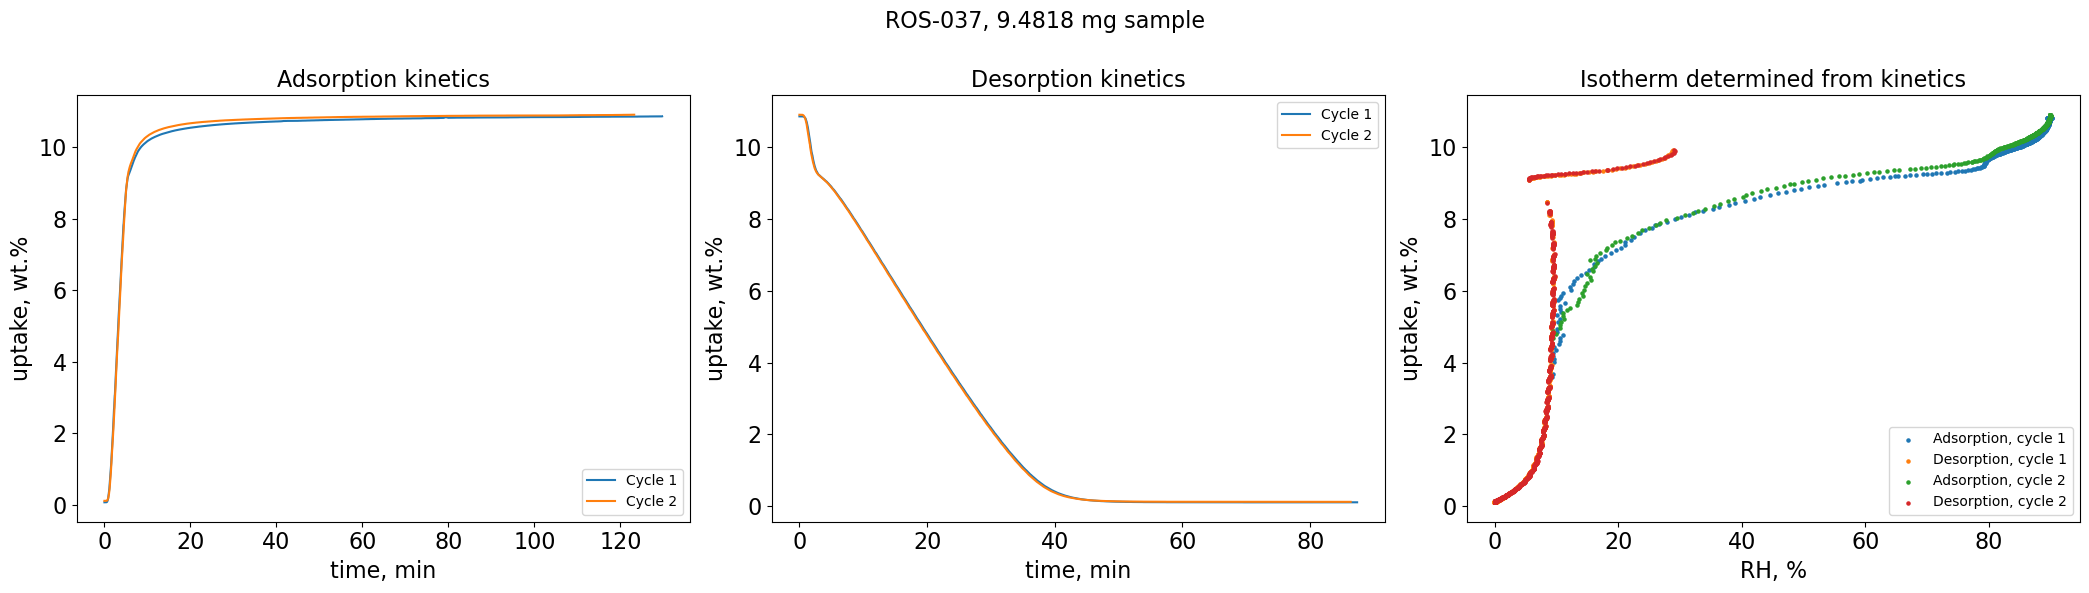

path_kinetics            ../../../../data/water_sorption/DVS/kinetics/
filename_kinetics    ROS039-SD-1-183_kinetics_8mg_50-100um-2021-06-...
path_isotherm           ../../../../data/water_sorption/DVS/isotherms/
filename_isotherm        SD-1-183_isotherm_27C-2021-05-18 18-59-58.xls
color                                                            green
name                                                           ROS-039
cycleNr                                                          '345'
analyze                                                              Y
to_paper                                                           NaN
Name: 9, dtype: object
File ROS039-SD-1-183_kinetics_8mg_50-100um-2021-06-04 18-28-36.xls read succesfull
Intersection:  [5.148140949101713, 21.88376419626246]
0.3
2.65
1.4749999999999999
0.8875
0.59375
0.446875
0.3734375
0.33671874999999996
0.318359375
0.3091796875
Fitting parameters: k:  0.3091796875
name 'Sorption_isotherm' is not defined
Intersection:  [4

C:\Users\Andrey.Bezrukov\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:230: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.


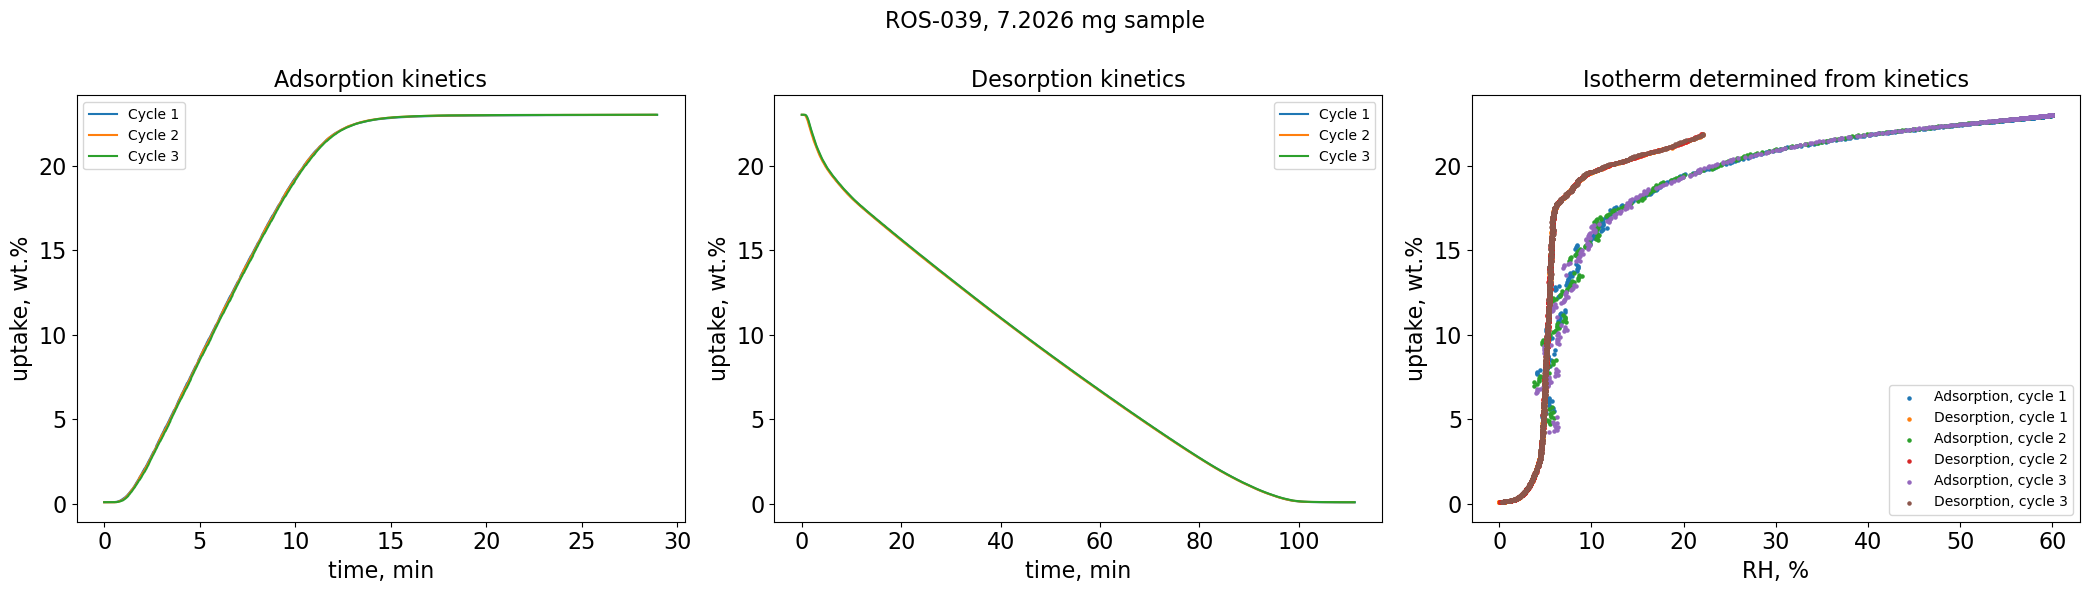

path_kinetics            ../../../../data/water_sorption/DVS/kinetics/
filename_kinetics    ROS-040_SD-1-82_kinetics_9mg_27C_50-100um-2021...
path_isotherm           ../../../../data/water_sorption/DVS/isotherms/
filename_isotherm    ROS-040_SD-01-082_isotherm_27C-2021-06-14 09-5...
color                                                            green
name                                                           ROS-040
cycleNr                                                          '345'
analyze                                                              Y
to_paper                                                           NaN
Name: 10, dtype: object
File ROS-040_SD-1-82_kinetics_9mg_27C_50-100um-2021-07-02 16-54-13.xls read succesfull
Intersection:  [3.710178913537338, 14.796746265219179]
0.3
2.65
1.4749999999999999
0.8875
0.59375
0.446875
0.3734375
0.33671874999999996
0.318359375
0.3275390625
Fitting parameters: k:  0.3275390625
name 'Sorption_isotherm' is not defined
Intersectio

C:\Users\Andrey.Bezrukov\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:230: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.


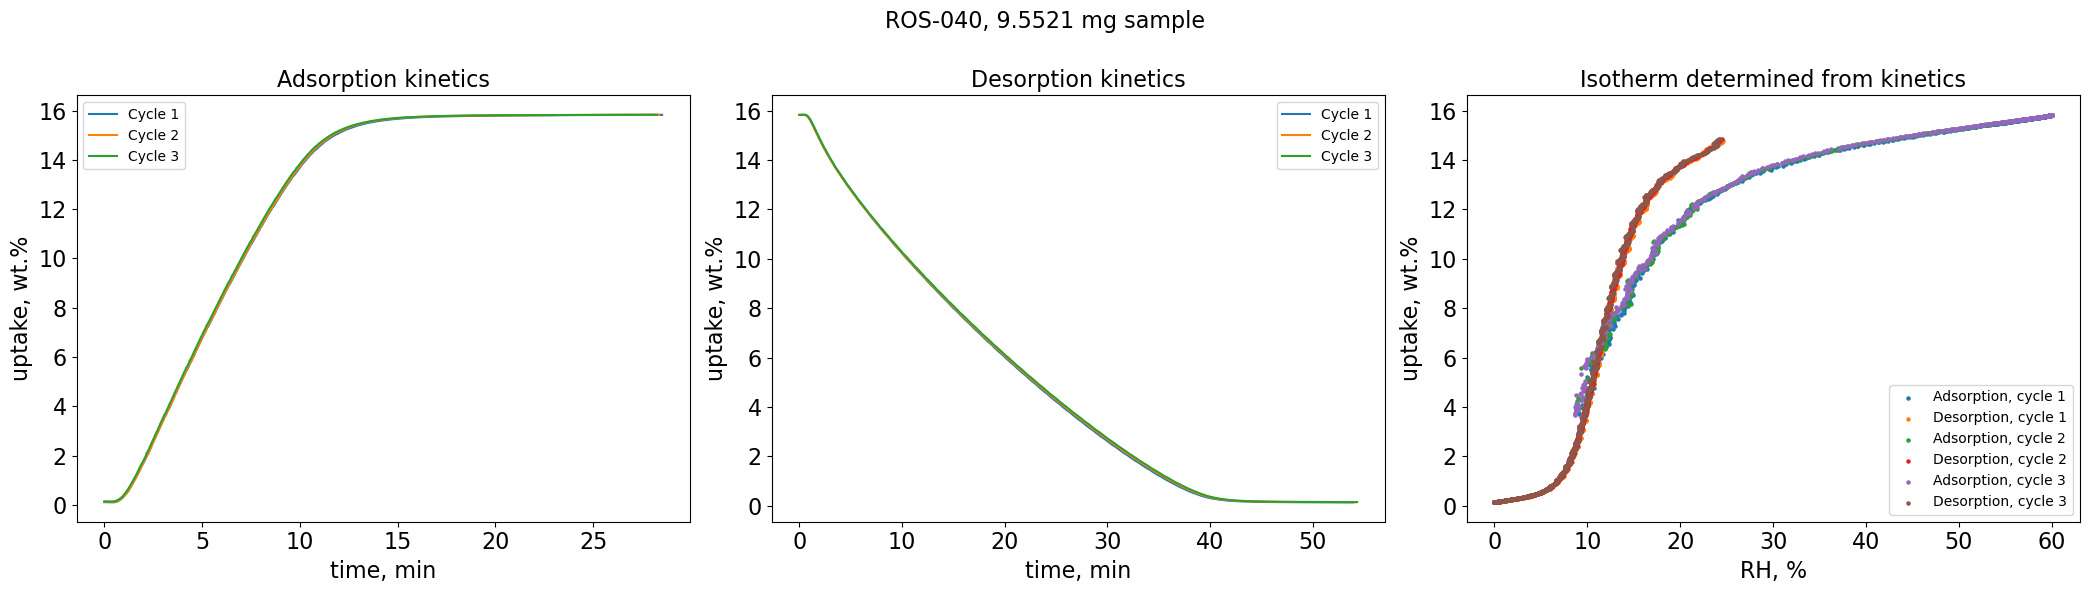

path_kinetics            ../../../../data/water_sorption/DVS/kinetics/
filename_kinetics    AAB-3-96_TGApan_kinetics_27C-2022-08-29 10-24-...
path_isotherm           ../../../../data/water_sorption/DVS/isotherms/
filename_isotherm    AAB-3-96_27C_isotherm_TGApan-2022-09-14 17-39-...
color                                                            green
name                                                  [Co2(mal)2(bpy)]
cycleNr                                                           '13'
analyze                                                              Y
to_paper                                                           NaN
Name: 11, dtype: object
File AAB-3-96_TGApan_kinetics_27C-2022-08-29 10-24-02.xls read succesfull
Intersection:  [2.4856133809003094, 10.861225148348007]
0.3
0.155
0.22749999999999998
0.26375
0.24562499999999998
0.25468749999999996
0.25015624999999997
0.25242187499999996
0.2535546875
0.25412109374999997
Fitting parameters: k:  0.25412109374999997
name 'Sorpti

C:\Users\Andrey.Bezrukov\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:230: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.


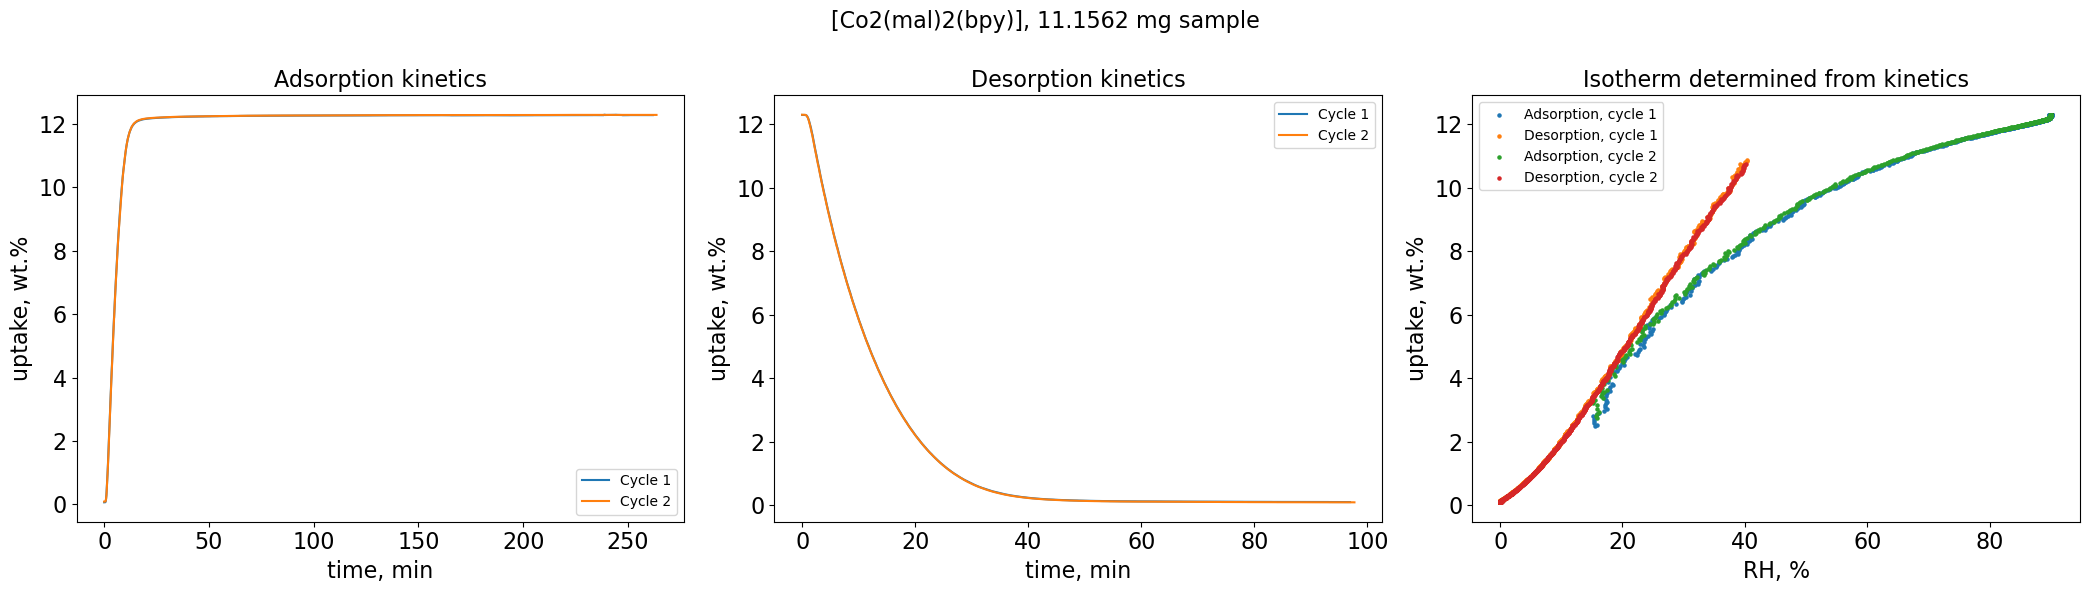

path_kinetics            ../../../../data/water_sorption/DVS/kinetics/
filename_kinetics       AAB-3-107_kinetics_27C-2022-08-18 21-17-17.xls
path_isotherm           ../../../../data/water_sorption/DVS/isotherms/
filename_isotherm    AAB-3-107_27C_isotherm_TGApan-2022-09-15 11-10...
color                                                            green
name                                                  [Ni2(mal)2(bpy)]
cycleNr                                                           '13'
analyze                                                              Y
to_paper                                                           NaN
Name: 12, dtype: object
File AAB-3-107_kinetics_27C-2022-08-18 21-17-17.xls read succesfull
Intersection:  [4.426429442571191, 10.68328328533507]
0.3
2.65
1.4749999999999999
0.8875
0.59375
0.446875
0.3734375
0.33671874999999996
0.318359375
0.3275390625
Fitting parameters: k:  0.3275390625
name 'Sorption_isotherm' is not defined
Intersection:  [4.2563004109743

C:\Users\Andrey.Bezrukov\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:230: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.


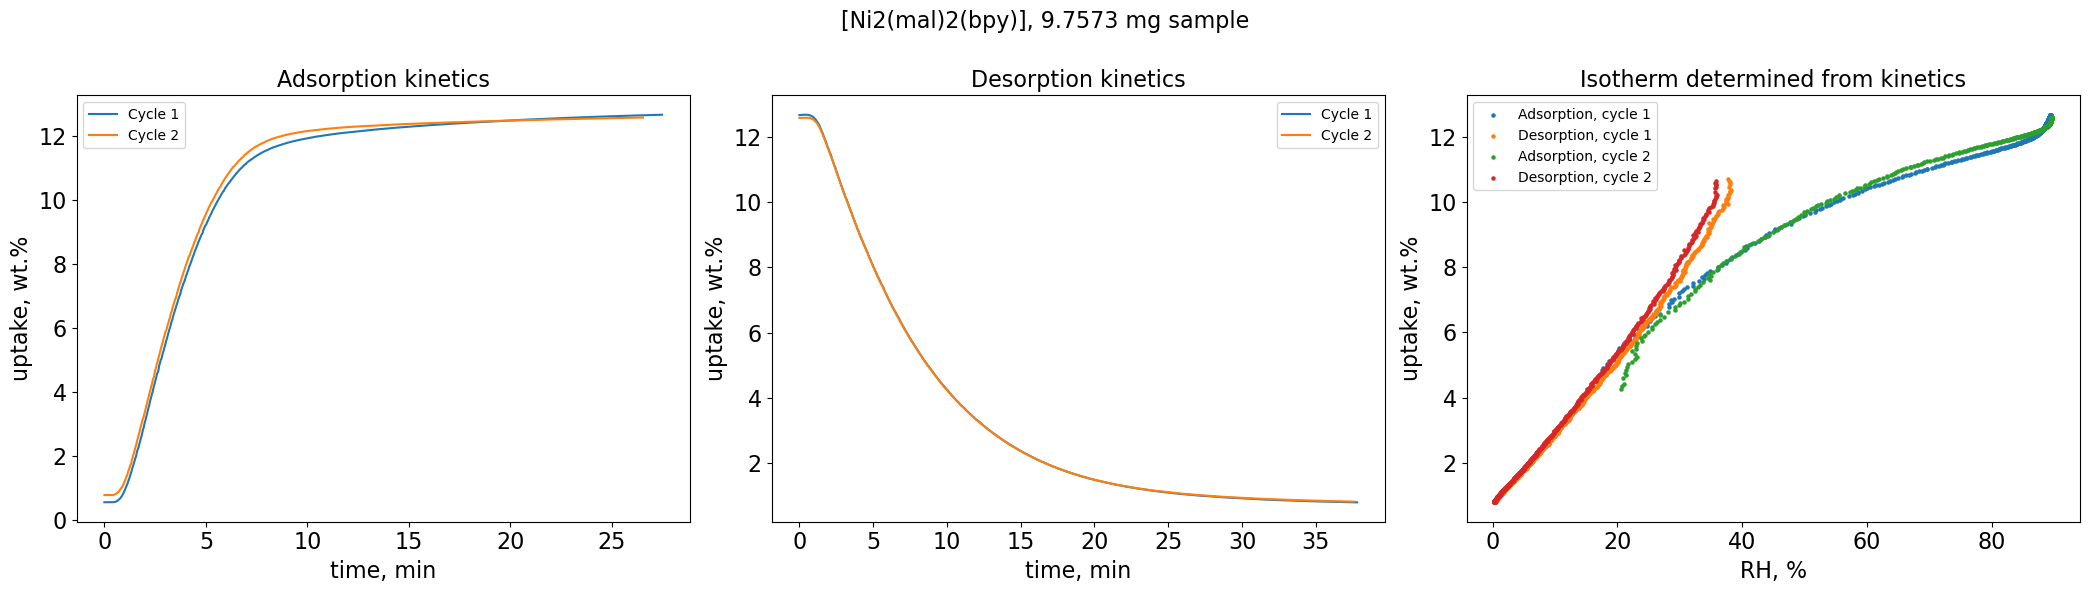

path_kinetics            ../../../../data/water_sorption/DVS/kinetics/
filename_kinetics       AAB-3-103_kinetics_27C-2022-08-18 21-17-17.xls
path_isotherm           ../../../../data/water_sorption/DVS/isotherms/
filename_isotherm    AAB-3-103_27C_isotherm_TGApan-2022-09-16 12-50...
color                                                            green
name                                                    [Ca2Zr(C2O4)2]
cycleNr                                                           '13'
analyze                                                              Y
to_paper                                                           NaN
Name: 13, dtype: object
File AAB-3-103_kinetics_27C-2022-08-18 21-17-17.xls read succesfull
Intersection:  [2.3535893445712714, 7.189321373684264]
0.3
2.65
1.4749999999999999
0.8875
0.59375
0.446875
0.3734375
0.33671874999999996
0.318359375
0.3275390625
Fitting parameters: k:  0.3275390625
name 'Sorption_isotherm' is not defined
Intersection:  [2.304294454808

C:\Users\Andrey.Bezrukov\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:230: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.


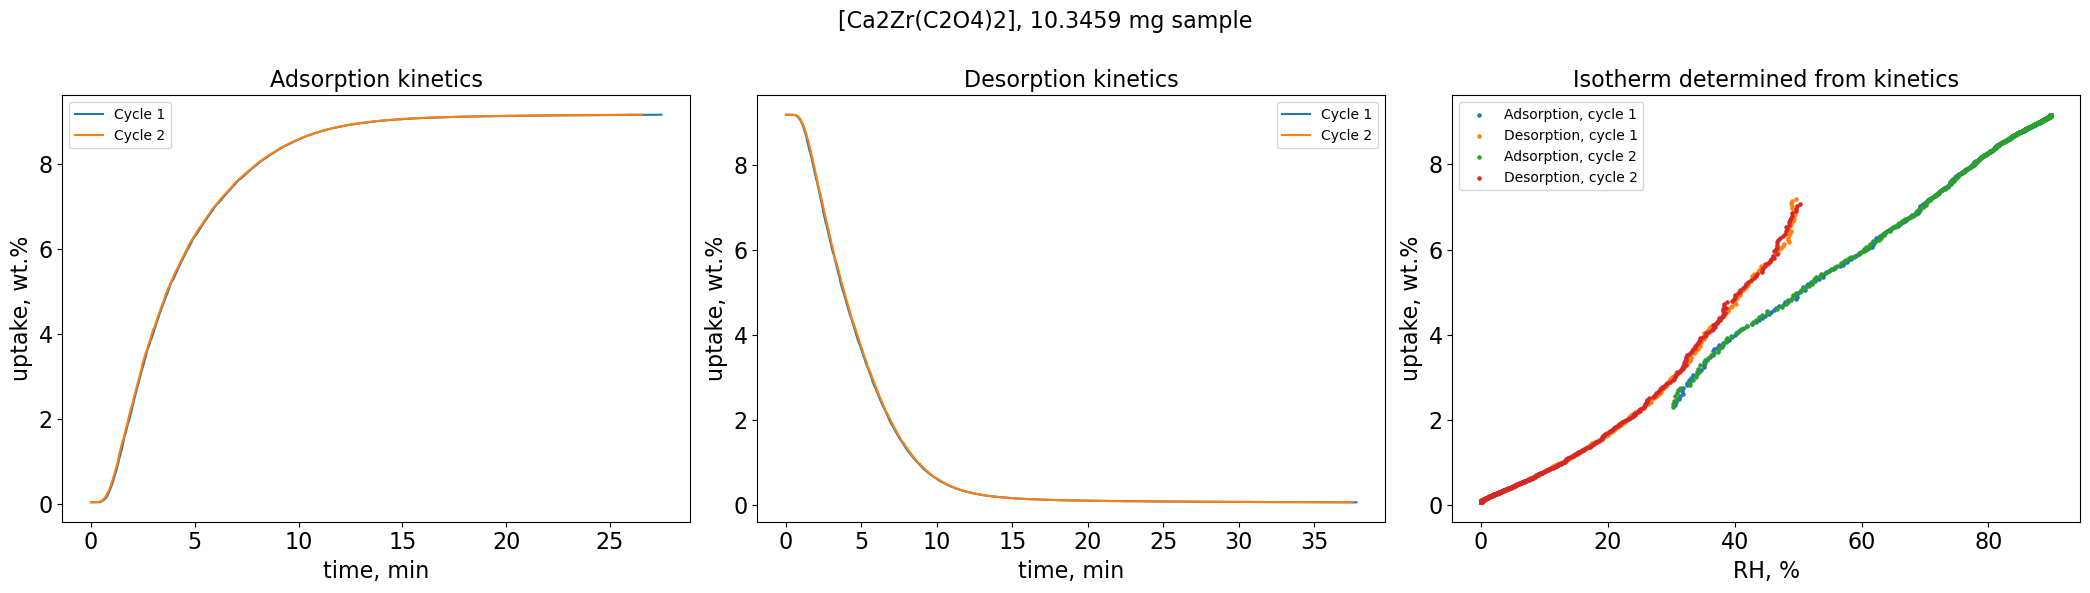

path_kinetics           ../../../../data/water_sorption/DVS/kinetics/
filename_kinetics    MS-2005-11_kinetics_10mg-2022-04-19 16-39-52.xls
path_isotherm          ../../../../data/water_sorption/DVS/isotherms/
filename_isotherm       2_MS-200512_Isotherm-2020-07-30 12-52-23.xlsx
color                                                           green
name                                                  [Cu(HQS)(TMBP)]
cycleNr                                                         '345'
analyze                                                             Y
to_paper                                                          NaN
Name: 14, dtype: object
File MS-2005-11_kinetics_10mg-2022-04-19 16-39-52.xls read succesfull
Intersection:  [3.1930490276400207, 12.910180673537143]
0.3
0.155
0.22749999999999998
0.26375
0.281875
0.2728125
0.27734375
0.279609375
0.2807421875
0.28130859375
Fitting parameters: k:  0.28130859375
name 'Sorption_isotherm' is not defined
Intersection:  [3.309473502651876, 

C:\Users\Andrey.Bezrukov\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:230: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.


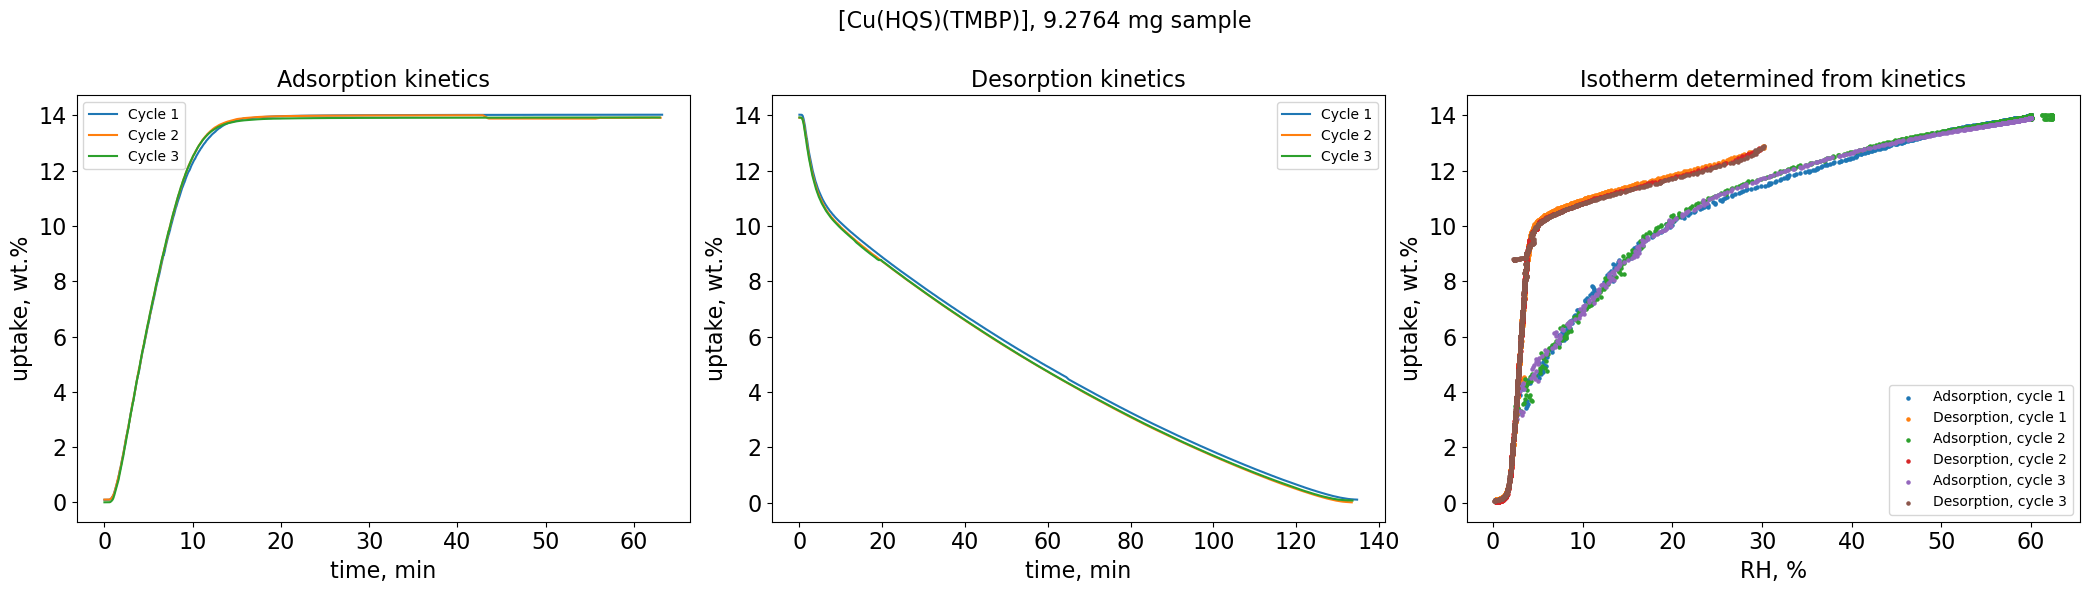

path_kinetics         ../../../../data/water_sorption/DVS/kinetics/
filename_kinetics       LX2134_kinetics_27C-2023-02-22 13-30-52.xls
path_isotherm        ../../../../data/water_sorption/DVS/isotherms/
filename_isotherm     LX2134_2_isotherm_25C-2022-01-13 19-26-53.xls
color                                                         green
name                                            sql-(azpy)(pdia)-Ni
cycleNr                                                        '13'
analyze                                                           Y
to_paper                                                        NaN
Name: 15, dtype: object
File LX2134_kinetics_27C-2023-02-22 13-30-52.xls read succesfull
Intersection:  [3.0827199913410435, 9.107452105206175]
0.3
2.65
1.4749999999999999
0.8875
0.59375
0.446875
0.3734375
0.33671874999999996
0.35507812499999997
0.34589843749999993
Fitting parameters: k:  0.34589843749999993
name 'Sorption_isotherm' is not defined
Intersection:  [3.4114893386730087, 9.

C:\Users\Andrey.Bezrukov\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:230: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.


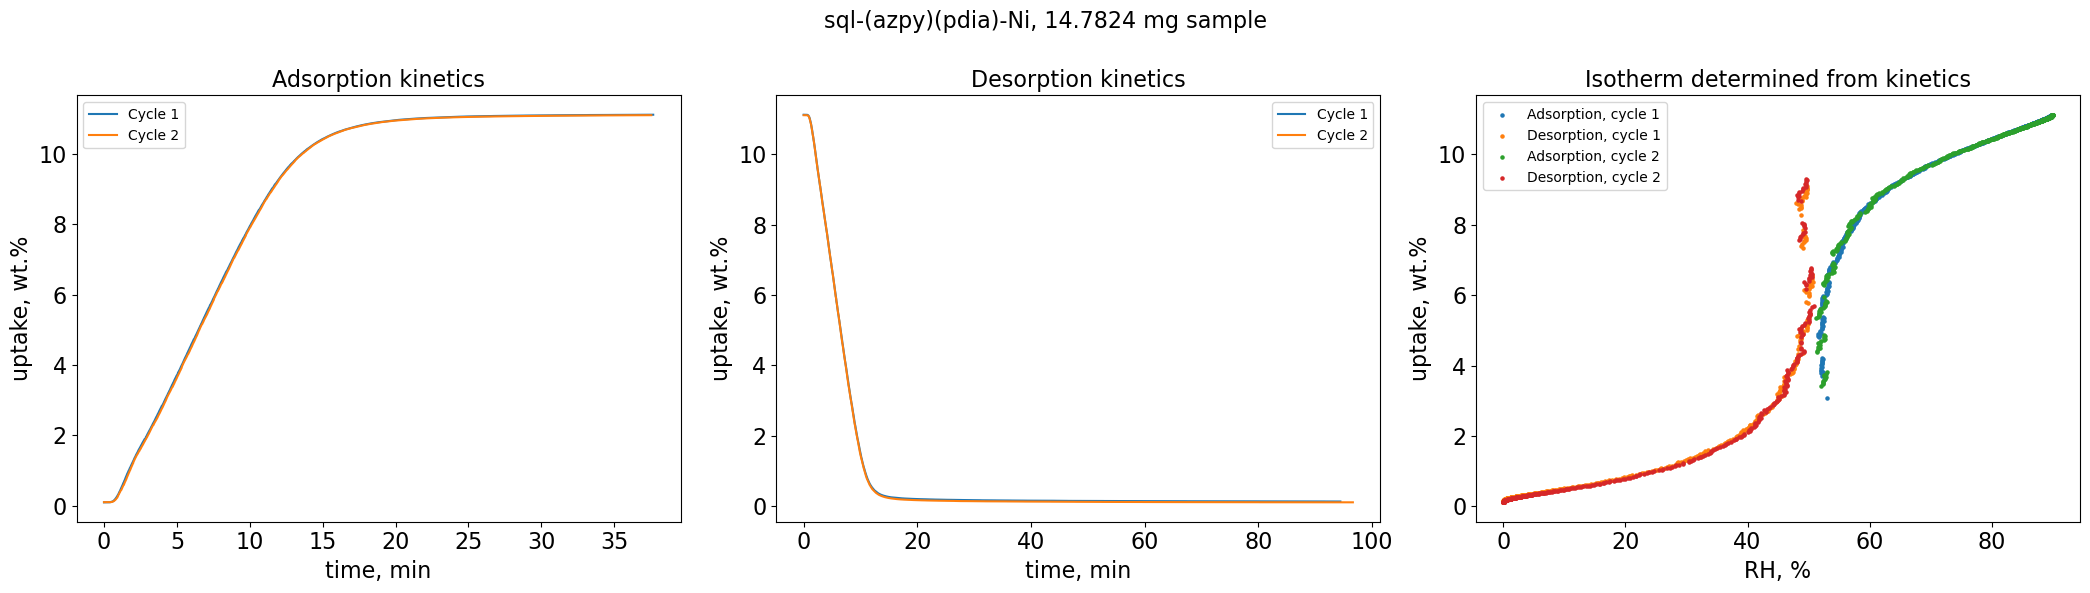

path_kinetics         ../../../../data/water_sorption/DVS/kinetics/
filename_kinetics     AAB-6-42_kinetics_27C-2023-02-22 13-30-52.xls
path_isotherm        ../../../../data/water_sorption/DVS/isotherms/
filename_isotherm     AAB-6-42_isotherm_27C-2023-02-18 20-04-00.xls
color                                                         green
name                                               [Cd(pzdc)(azpy)]
cycleNr                                                         02'
analyze                                                           Y
to_paper                                                        NaN
Name: 16, dtype: object
File AAB-6-42_kinetics_27C-2023-02-22 13-30-52.xls read succesfull
Intersection:  [2.7765163116372906, 5.899437092737125]
0.3
2.65
1.4749999999999999
0.8875
0.59375
0.446875
0.3734375
0.33671874999999996
0.35507812499999997
0.34589843749999993
Fitting parameters: k:  0.34589843749999993
name 'Sorption_isotherm' is not defined
Intersection:  [3.1915680082799027, 

C:\Users\Andrey.Bezrukov\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:230: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.


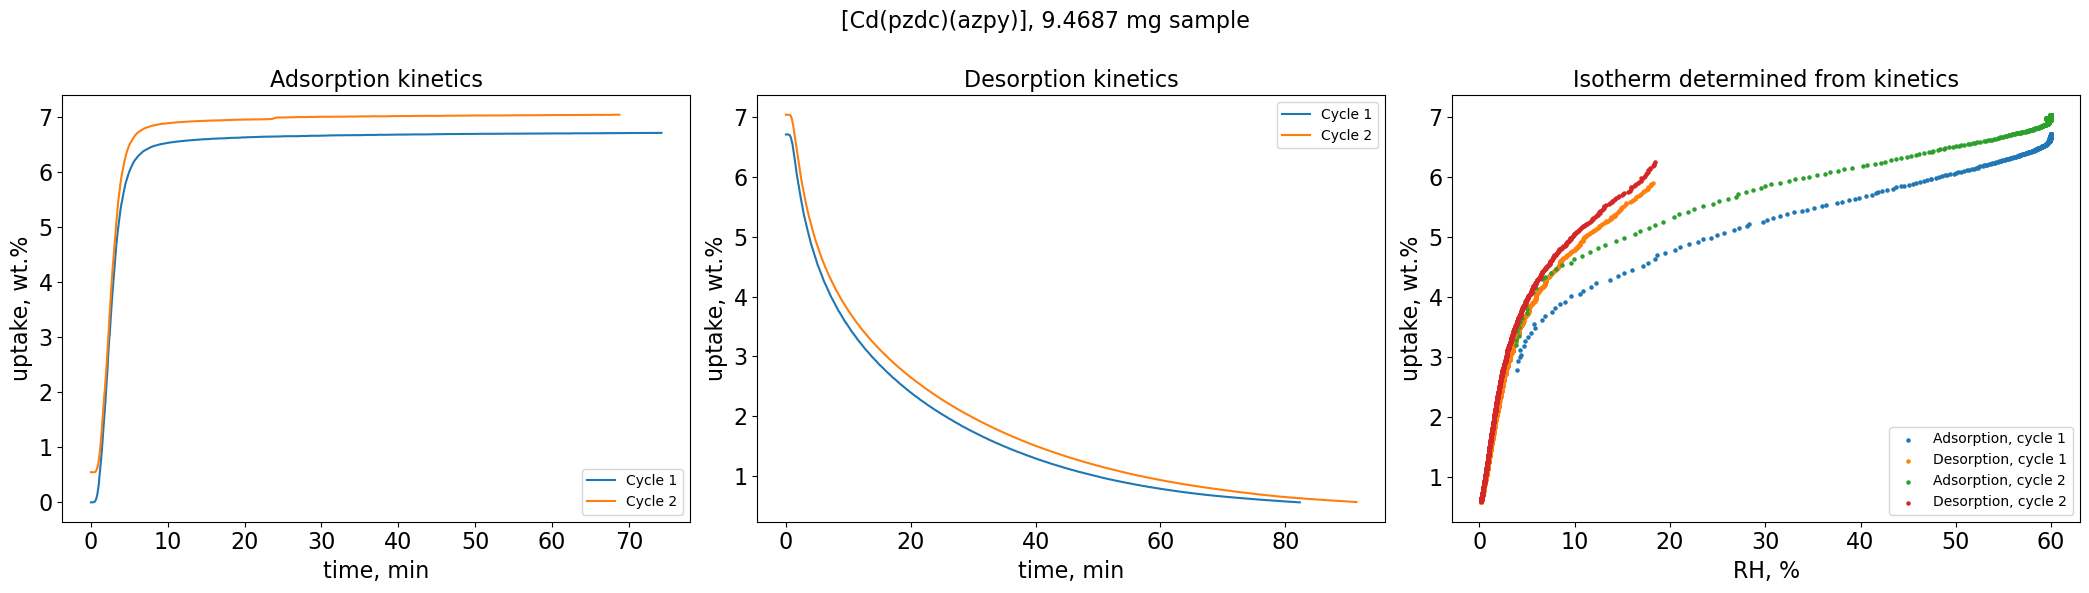

path_kinetics         ../../../../data/water_sorption/DVS/kinetics/
filename_kinetics     AAB-6-41_kinetics_27C-2023-02-25 16-19-20.xls
path_isotherm        ../../../../data/water_sorption/DVS/isotherms/
filename_isotherm    AAB-6-41_isotherm_27C-2023-02-23 16-37-53.xlsx
color                                                         green
name                                                       ZPF-2-Co
cycleNr                                                         02'
analyze                                                           Y
to_paper                                                        NaN
Name: 17, dtype: object
File AAB-6-41_kinetics_27C-2023-02-25 16-19-20.xls read succesfull
Intersection:  [1.3293872538874423, 15.133076700194545]
0.3
2.65
1.4749999999999999
0.8875
0.59375
0.446875
0.3734375
0.41015625
0.428515625
0.43769531250000004
Fitting parameters: k:  0.43769531250000004
name 'Sorption_isotherm' is not defined
Intersection:  [1.0368806655904608, 15.0978931247154

C:\Users\Andrey.Bezrukov\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:230: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.


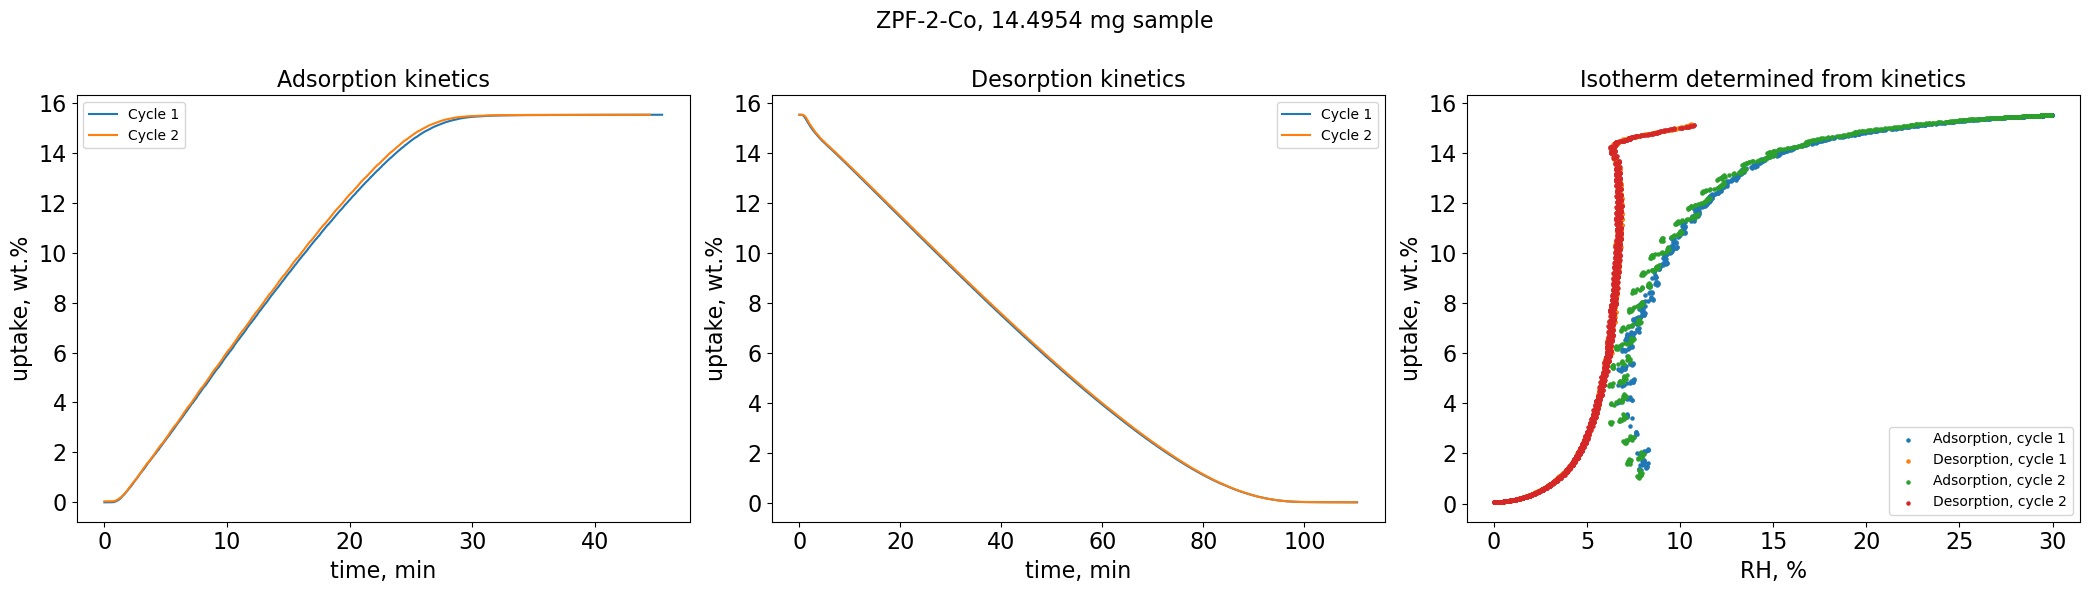

path_kinetics            ../../../../data/water_sorption/DVS/kinetics/
filename_kinetics    AAB-6-35_ground_kinetics_27C_20mg-2023-02-27 1...
path_isotherm           ../../../../data/water_sorption/DVS/isotherms/
filename_isotherm        AAB-6-35_isotherm_27C-2023-02-19 21-31-48.xls
color                                                            green
name                                                    MIL-53(Al)-ADP
cycleNr                                                            13'
analyze                                                              Y
to_paper                                                           NaN
Name: 18, dtype: object
File AAB-6-35_ground_kinetics_27C_20mg-2023-02-27 18-31-39.xls read succesfull
Intersection:  [1.885589360539267, 11.197394789579162]
0.3
0.155
0.22749999999999998
0.26375
0.24562499999999998
0.25468749999999996
0.25921874999999994
0.25695312499999995
0.2580859375
0.25751953124999993
Fitting parameters: k:  0.25751953124999993
name 'So

C:\Users\Andrey.Bezrukov\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:230: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.


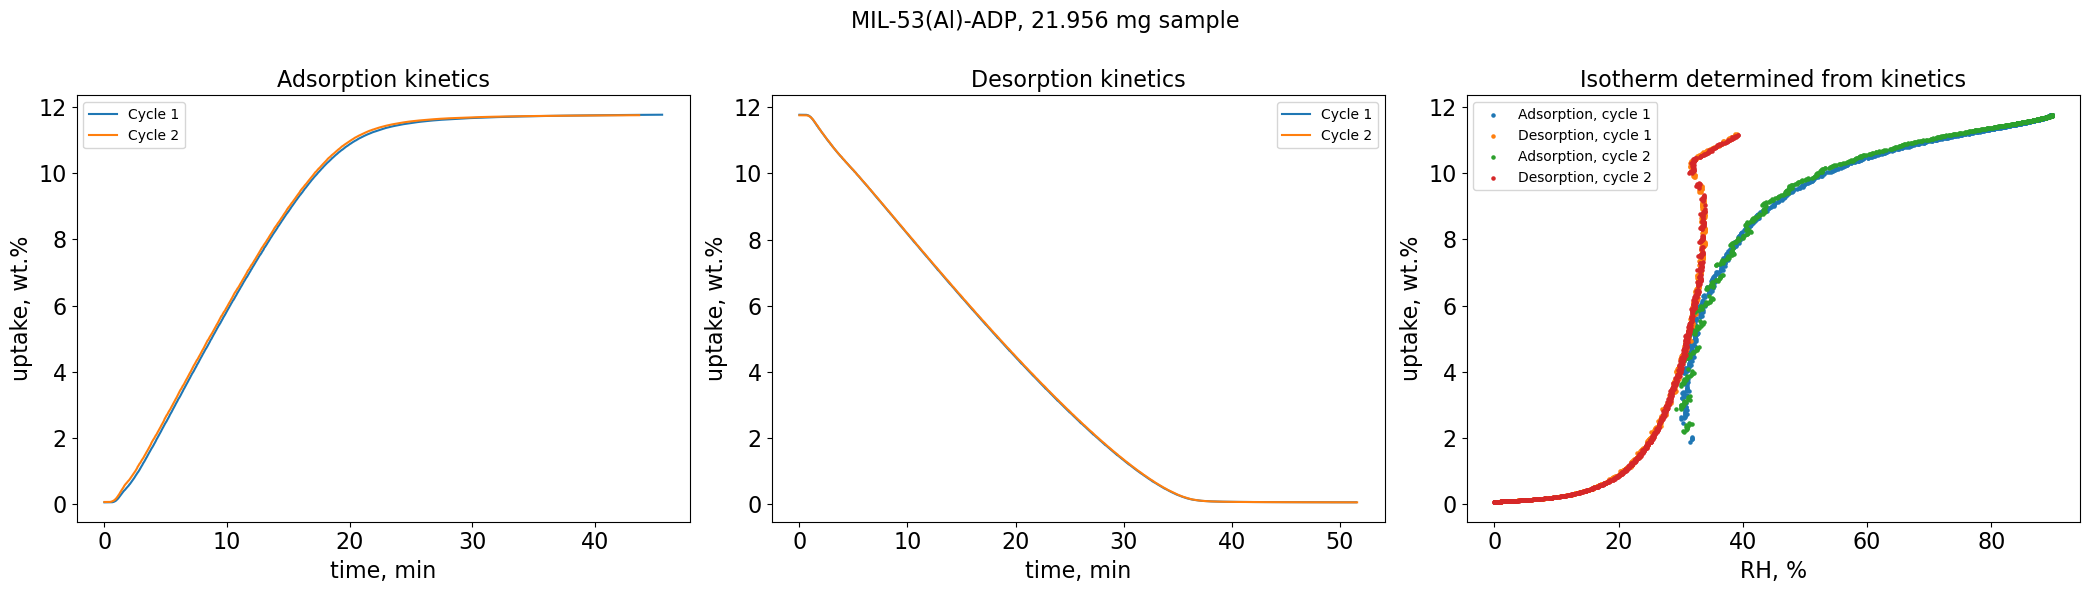

path_kinetics            ../../../../data/water_sorption/DVS/kinetics/
filename_kinetics    AAB-6-40_refluxEtOH_kinetics_27C-2023-02-25 16...
path_isotherm           ../../../../data/water_sorption/DVS/isotherms/
filename_isotherm    AAB-6-40_refluxEtOH_isotherm_27C-2023-02-23 16...
color                                                            green
name                                                     MIL-53(Al)-OH
cycleNr                                                            13'
analyze                                                              Y
to_paper                                                           NaN
Name: 19, dtype: object
File AAB-6-40_refluxEtOH_kinetics_27C-2023-02-25 16-19-20.xls read succesfull
Intersection:  [3.630738736808267, 35.61030160175711]
0.3
2.65
1.4749999999999999
0.8875
0.59375
0.446875
0.3734375
0.41015625
0.391796875
0.4009765625
Fitting parameters: k:  0.4009765625
name 'Sorption_isotherm' is not defined
Intersection:  [4.518669309476

C:\Users\Andrey.Bezrukov\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:230: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.


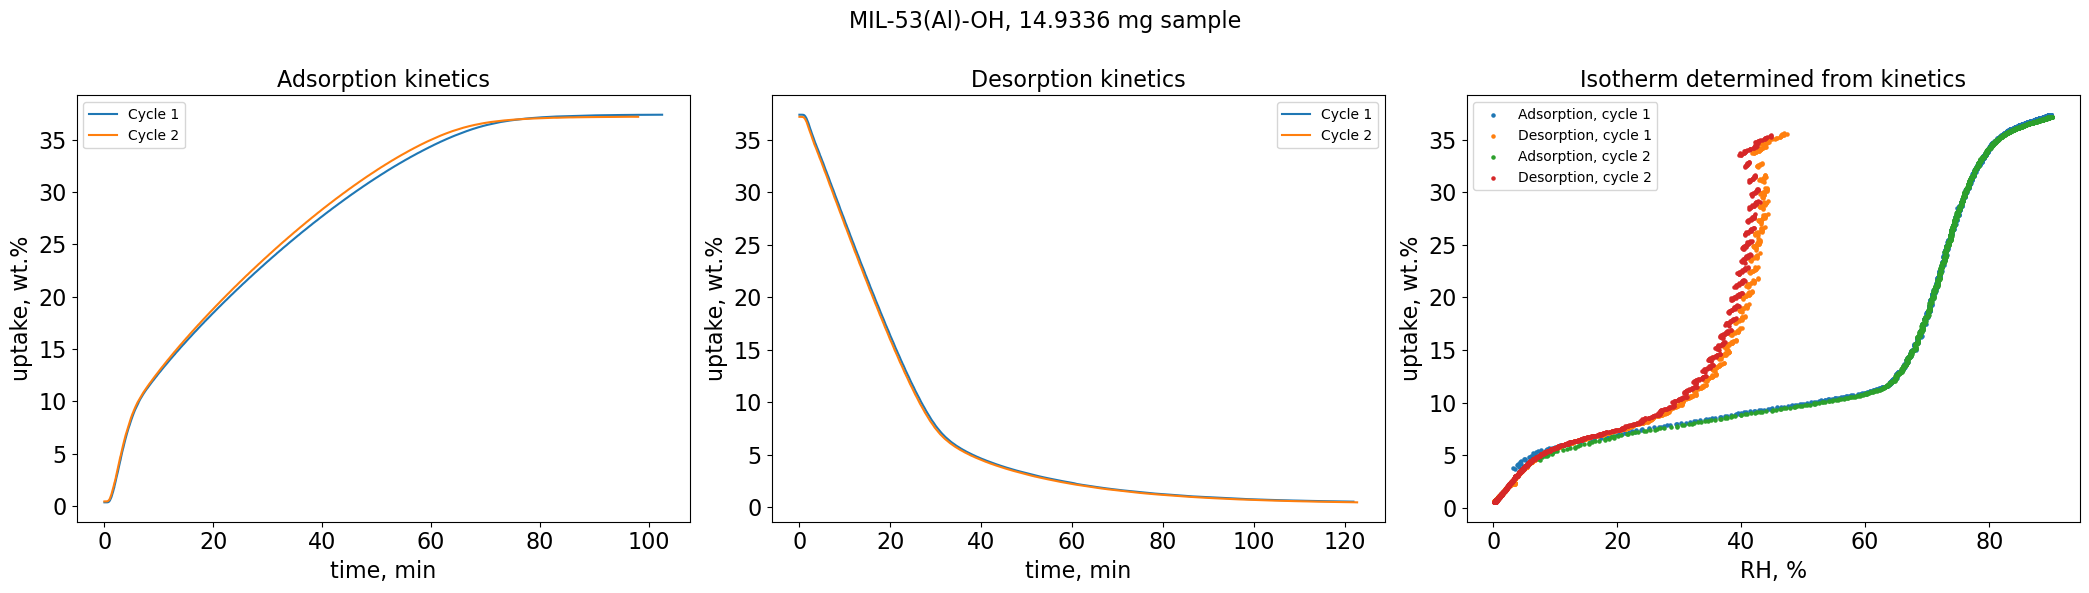

In [12]:
for indx in import_parameters[import_parameters.analyze=='Y'].index:
    print(import_parameters.iloc[indx, :])
    ## import kinetics
    Sorption_kinetics = file_Sorption()
    try:
        Sorption_kinetics.read_file(import_parameters.path_kinetics[indx],import_parameters.filename_kinetics[indx])
        if Sorption_kinetics.import_success:
            if Sorption_kinetics.fluid != 'water vapor':
                del Sorption_kinetics
                print('Wrong fluid: ',Sorption_kinetics.fluid)
        else:
            del Sorption_kinetics
            print(import_parameters.filename_kinetics[indx], 'failed')
            continue
    except Exception as e:
        print(e)
        print(import_parameters.filename_kinetics[indx], 'failed')
        continue
        
    
    Sorption_kinetics.data['cycle_split'] = Sorption_kinetics.data['RH_target'].diff().fillna(0)
    Sorption_kinetics.data['cycle_split_temp'] = Sorption_kinetics.data['temp_target'].diff().fillna(0)
    split_index_ads = Sorption_kinetics.data.index[(Sorption_kinetics.data['cycle_split']>0)].to_list()
    split_index_des = Sorption_kinetics.data.index[(Sorption_kinetics.data['cycle_split']<0)].to_list()
    split_index_temp = Sorption_kinetics.data.index[(Sorption_kinetics.data['cycle_split_temp']!=0)].to_list()
    
    
    fig, ax = plt.subplot_mosaic(    
    """
    AABBHH
    """
                              ,figsize=(21, 6), constrained_layout=True)
    fig.suptitle(''.join([import_parameters.name[indx], ', ', str(Sorption_kinetics.sample_mass), ' mg sample' ]),
                         fontsize=text_size)
    
    for cycleNr_ordered, cycleNr in enumerate([int(i) for i in list(str(import_parameters.cycleNr[indx]).replace('\'', ''))]):
        # uptake adsorption
        try:
            w_ads = pd.DataFrame({'time':Sorption_kinetics.data.iloc[split_index_ads[cycleNr]:split_index_des[cycleNr], :]['time'] - Sorption_kinetics.data.iloc[split_index_ads[cycleNr]:split_index_des[cycleNr], :]['time'].min(), 
                                  'uptake':Sorption_kinetics.data.iloc[split_index_ads[cycleNr]:split_index_des[cycleNr], :]['uptake'],
                                  'RH_actual':Sorption_kinetics.data.iloc[split_index_ads[cycleNr]:split_index_des[cycleNr], :]['RH_actual']
                                  })
        except Exception as e:
            print(e)
            continue
        ax['A'].plot(w_ads['time'],
                      w_ads['uptake'],
                      #c=import_parameters.color[indx],
                      label=''.join(['Cycle ', str(cycleNr_ordered+1)])
                      )
        #ax['A'].legend()
        ax['A'].set_xlabel('time, min', fontsize=text_size)
        ax['A'].set_ylabel('uptake, wt.%', fontsize=text_size)
        ax['A'].tick_params(axis='x', labelsize=text_size)
        ax['A'].tick_params(axis='y', labelsize=text_size)
        ax['A'].set_title('Adsorption kinetics', fontsize=text_size)
        ax['A'].legend()
        '''
        ax2 = ax['A'].twinx()
        ax2.plot(w_ads['time'],
                 w_ads['RH_actual'], 
                 c='b'
                 )
        ax2.set_ylabel('RH actual, %', fontsize=text_size, c='b')
        ax2.tick_params(axis='y', labelsize=text_size)
        '''
        # first derivative adsorption
        first_derivative_dwdt_ads = pd.DataFrame({'dwdt':(w_ads['uptake'].diff()/w_ads['time'].diff()).rolling(window=window1, min_periods=1, center=True).mean(),
                                                  'uptake':w_ads['uptake']
                                                  })

        # first derivative adsorption where second derivative is negatinve
        first_derivative_dwdt_dw_ads = pd.DataFrame({'dwdt_dw':(first_derivative_dwdt_ads['dwdt'].diff()/first_derivative_dwdt_ads['uptake'].diff()).rolling(window=window2, min_periods=1, center=True).mean(),
                                                     'uptake':first_derivative_dwdt_ads['uptake']
                                                     })
        def normalize(x):
            return (x-x.min())/(x.max()-x.min())
        X = np.array([[i[0], i[1]] for i in zip(normalize(first_derivative_dwdt_ads[first_derivative_dwdt_dw_ads['dwdt_dw']<0]['uptake']), normalize(first_derivative_dwdt_ads[first_derivative_dwdt_dw_ads['dwdt_dw']<0]['dwdt']))  ])
        clustering_ads = DBSCAN(eps=0.1, min_samples=1).fit(X)
        #print(clustering_ads.labels_)

        # uptake desorption
        try:
            temp_index = [split_index_des[cycleNr], split_index_ads[cycleNr+1]]
        except: 
            temp_index = [split_index_des[cycleNr], Sorption_kinetics.data.index.max()]
        if [i for i in split_index_temp if (i>temp_index[0])&(i<temp_index[1])] != []:
            temp_index = [temp_index[0], min(min([i for i in split_index_temp if (i>temp_index[0])&(i<temp_index[1])]), temp_index[1])]
        try:
            w_des = pd.DataFrame({'time':Sorption_kinetics.data.iloc[temp_index[0]:temp_index[1], :]['time'] - Sorption_kinetics.data.iloc[temp_index[0]:temp_index[1], :]['time'].min(), 
                                  'uptake':Sorption_kinetics.data.iloc[temp_index[0]:temp_index[1], :]['uptake'], 
                                  'RH_actual':Sorption_kinetics.data.iloc[temp_index[0]:temp_index[1], :]['RH_actual'], 
                                  })
        except Exception as e:
            print(e)
            continue      
        ax['B'].plot(w_des['time'],
                      w_des['uptake'],
                      #c=import_parameters.color[indx],
                      label=''.join(['Cycle ', str(cycleNr_ordered+1)])
                      )
        #ax['B'].legend()
        ax['B'].set_xlabel('time, min', fontsize=text_size)
        ax['B'].set_ylabel('uptake, wt.%', fontsize=text_size)
        ax['B'].tick_params(axis='x', labelsize=text_size)
        ax['B'].tick_params(axis='y', labelsize=text_size)
        ax['B'].set_title('Desorption kinetics', fontsize=text_size)
        ax['B'].legend()
        '''
        ax3 = ax['B'].twinx()
        ax3.plot(w_des['time'],
                 w_des['RH_actual'], 
                 c='b'
                 )
        ax3.set_ylabel('RH actual, %', fontsize=text_size, c='b')
        ax3.tick_params(axis='y', labelsize=text_size)
        '''
        
        # first derivative adsorption
        first_derivative_dwdt_des = pd.DataFrame({'dwdt':(w_des['uptake'].diff()/w_des['time'].diff()).rolling(window=window1, min_periods=1, center=True).mean(),
                                                  'uptake':w_des['uptake']
                                                  })

        # first derivative desorption where second derivative is negatinve
        first_derivative_dwdt_dw_des = pd.DataFrame({'dwdt_dw':(first_derivative_dwdt_des['dwdt'].diff()/first_derivative_dwdt_des['uptake'].diff()).rolling(window=window2, min_periods=1, center=True).mean(),
                                                     'uptake':first_derivative_dwdt_des['uptake']
                                                     })
        def normalize(x):
            return (x-x.min())/(x.max()-x.min())
        X = np.array([[i[0], i[1]] for i in zip(normalize(first_derivative_dwdt_des[first_derivative_dwdt_dw_des['dwdt_dw']<0]['uptake']), normalize(first_derivative_dwdt_des[first_derivative_dwdt_dw_des['dwdt_dw']<0]['dwdt']))  ])
        clustering_des = DBSCAN(eps=0.1, min_samples=1).fit(X)
        #print(clustering_des.labels_)

        ### perform RH calibration
        ### use DVS adventure k for TGA pan = 0.3
        k_adventure_TGA_min = 0.01
        k_adventure_TGA_max = 5
        k_adventure_TGA_start = 0.3

        try:

            f_des = interpolate.interp1d(first_derivative_dwdt_des['uptake'],  first_derivative_dwdt_des['dwdt'], fill_value="extrapolate")
            def interpolate_first_derivative_dwdt_dw_des(t):
                return f_des(t)
            f_ads = interpolate.interp1d(first_derivative_dwdt_ads['uptake'],  first_derivative_dwdt_ads['dwdt'], fill_value="extrapolate")
            def interpolate_first_derivative_dwdt_dw_ads(t):
                return f_ads(t)

            first_derivative_dwdt_dw_intersection = [first_derivative_dwdt_ads['uptake'][first_derivative_dwdt_dw_ads['dwdt_dw']<0][clustering_ads.labels_==np.bincount(clustering_ads.labels_).argmax()].min(),
                                                    first_derivative_dwdt_des['uptake'][first_derivative_dwdt_dw_des['dwdt_dw']<0][clustering_des.labels_==np.bincount(clustering_des.labels_).argmax()].max()]
            print('Intersection: ',first_derivative_dwdt_dw_intersection)
            desdata_interpolated = interpolate_first_derivative_dwdt_dw_des(first_derivative_dwdt_ads[(first_derivative_dwdt_ads.uptake>first_derivative_dwdt_dw_intersection[0])&(first_derivative_dwdt_ads.uptake<first_derivative_dwdt_dw_intersection[1])]['uptake'])
            adsdata_interpolated = interpolate_first_derivative_dwdt_dw_ads(first_derivative_dwdt_ads[(first_derivative_dwdt_ads.uptake>first_derivative_dwdt_dw_intersection[0])&(first_derivative_dwdt_ads.uptake<first_derivative_dwdt_dw_intersection[1])]['uptake'])
            RH_max = Sorption_kinetics.data.iloc[split_index_ads[cycleNr]:split_index_des[cycleNr], :]['RH_target'].max()

            for attempt in range(10):
                if attempt == 0:
                    k_adventure_TGA = k_adventure_TGA_start
                else:
                    k_adventure_TGA = (k_adventure_TGA_min+k_adventure_TGA_max)/2
                print(k_adventure_TGA)
                if ((-desdata_interpolated/k_adventure_TGA*Sorption_kinetics.sample_mass)<(RH_max - adsdata_interpolated/k_adventure_TGA*Sorption_kinetics.sample_mass)).all():
                    k_adventure_TGA_max = k_adventure_TGA
                else: 
                    k_adventure_TGA_min = k_adventure_TGA

            print('Fitting parameters: k: ',k_adventure_TGA)

            first_derivative_dwdt_ads['dwdt_scaled'] = RH_max - first_derivative_dwdt_ads['dwdt']/k_adventure_TGA*Sorption_kinetics.sample_mass
            first_derivative_dwdt_des['dwdt_scaled'] = -first_derivative_dwdt_des['dwdt']/k_adventure_TGA*Sorption_kinetics.sample_mass
            #frames = [first_derivative_dwdt_ads[first_derivative_dwdt_dw_ads['dwdt_dw']<0][clustering_ads.labels_==np.bincount(clustering_ads.labels_).argmax()][['uptake', 'dwdt_scaled']],
            #          first_derivative_dwdt_des[first_derivative_dwdt_dw_des['dwdt_dw']<0][clustering_des.labels_==np.bincount(clustering_des.labels_).argmax()][['uptake', 'dwdt_scaled']]]
            #joined_first_derivative_dwdt = pd.concat(frames, sort=True)
            #joined_first_derivative_dwdt = joined_first_derivative_dwdt.sort_values(by=['uptake'])
            #ax[0, 2].plot(joined_first_derivative_dwdt['uptake'], joined_first_derivative_dwdt['dwdt'])   

            #ax[0, 2].set_title(popt)

            ax['H'].scatter(first_derivative_dwdt_ads[first_derivative_dwdt_dw_ads['dwdt_dw']<0][clustering_ads.labels_==np.bincount(clustering_ads.labels_).argmax()]['dwdt_scaled'],
                             first_derivative_dwdt_ads[first_derivative_dwdt_dw_ads['dwdt_dw']<0][clustering_ads.labels_==np.bincount(clustering_ads.labels_).argmax()]['uptake'],
                         #c=import_parameters.color[indx],
                         label=''.join(['Adsorption, cycle ', str(cycleNr_ordered+1)]),
                         s=5)
            ax['H'].scatter(first_derivative_dwdt_des[first_derivative_dwdt_dw_des['dwdt_dw']<0][clustering_des.labels_==np.bincount(clustering_des.labels_).argmax()]['dwdt_scaled'],
                             first_derivative_dwdt_des[first_derivative_dwdt_dw_des['dwdt_dw']<0][clustering_des.labels_==np.bincount(clustering_des.labels_).argmax()]['uptake'],
                         #c=import_parameters.color[indx],
                         label=''.join(['Desorption, cycle ', str(cycleNr_ordered+1)]),
                         s=5)
            ax['H'].set_xlabel('RH, %', fontsize=text_size)
            ax['H'].set_ylabel('uptake, wt.%', fontsize=text_size)
            ax['H'].tick_params(axis='x', labelsize=text_size)
            ax['H'].tick_params(axis='y', labelsize=text_size)
            ax['H'].set_title('Isotherm determined from kinetics', fontsize=text_size)
            ax['H'].legend()  

        except Exception as e: 
            print(e)
            pass

        # plot experimental isotherm
        try:
            isotherm_RHtarget_ads, isotherm_adsorption, isotherm_RHtarget_des, isotherm_desorption, time1 = Create_WaterSorption_isotherm(Sorption_isotherm)

            exp_isotherm_ads = pd.DataFrame({'RH_ads':isotherm_RHtarget_ads, 
                                     'ads':isotherm_adsorption, })
            exp_isotherm_des = pd.DataFrame({'RH_des':isotherm_RHtarget_des, 
                                     'des':isotherm_desorption
                                    })

            #ax[1, 2].set_xlim([(-joined_first_derivative_dwdt['dwdt_scaled']).min(), (-joined_first_derivative_dwdt['dwdt_scaled']).max()])
            #ax[1, 2].set_ylim(limy)


        except Exception as e: 
            print(e)
            pass
    save_filename = ''
    
    save_filename += import_parameters.name[indx]
    #save_filename += '__'
    #try:
    #    save_filename += import_parameters.filename_isotherm[indx]
    #    save_filename += '__'
    #except: pass
    #save_filename += str(import_parameters.cycleNr[indx])
    #save_filename += '__'
    #save_filename += import_parameters.filename_kinetics[indx]
    save_filename += '.png'

    fig.tight_layout(rect=[0, 0, 1, 0.97])
    plt.savefig(save_filename, dpi=300)
    plt.show()
